#Importing Libraries

In [1]:
!pip install transformers tensorflow tensorflow-text

In [2]:
# Standard libs
import os
import glob
import math
import random
import itertools
import warnings
from collections import OrderedDict

# Data & plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# OpenCV for video processing
import cv2

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import (
    Input, Conv1D, Conv2D, DepthwiseConv2D, Dense, Flatten, Dropout,
    BatchNormalization, LSTM, Bidirectional, MaxPooling1D, MaxPooling2D,
    GlobalAveragePooling1D, GlobalAveragePooling2D, Reshape, Permute,
    AveragePooling2D, Activation
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score,
    f1_score, precision_score, recall_score, classification_report
)
from sklearn.utils.class_weight import compute_class_weight

# XGBoost
import xgboost as xgb

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
np.random.seed(42)
tf.random.set_seed(42)

#Utils

In [3]:
EEG_CSV = "/content/EEG_data.csv"
DEMO_CSV = "/content/demographic_info.csv"   # optional
VIDEOS_DIR = "/content/videos"
OUT_DIR = "./artifacts_three_models"
os.makedirs(OUT_DIR, exist_ok=True)

# training / data params
SEED = 42
ORIG_T = 120               # original frames per trial in your data (was implicit before)
WINDOW_SIZE = 30           # <--- choose window length here (e.g. 30)
WINDOW_STRIDE = 10         # <--- choose stride here (e.g. 10)
T_TARGET = WINDOW_SIZE     # keep rest of notebook using T_TARGET (so models use window length)
BATCH_SIZE = 8
EPOCHS = 40
NUM_FRAMES_FOR_VIDEO = 16   # frames to sample per video for hybrid temporal branch
IMG_SIZE = (128,128)
USE_AUGMENTATION = True

# reproducible seeds
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

# resample helper: linearly resamples a (T,C) array -> (T_target, C)
def resample_to_fixed_np(arr, T_target=T_TARGET):
    T, C = arr.shape
    if T == T_target:
        return arr.astype(np.float32)
    x_old = np.linspace(0.0, 1.0, T)
    x_new = np.linspace(0.0, 1.0, T_target)
    out = np.zeros((T_target, C), dtype=np.float32)
    for ci in range(C):
        out[:, ci] = np.interp(x_new, x_old, arr[:, ci])
    return out


#Load Dataset

EEG rows: 12811 Demo rows: 10
EEG columns: ['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'predefinedlabel', 'user-definedlabeln']
Demo columns: ['subjectid', 'age', 'ethnicity', 'gender']
Using label col: user-definedlabeln
FEATURE_COLS: ['Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2', 'predefinedlabel']


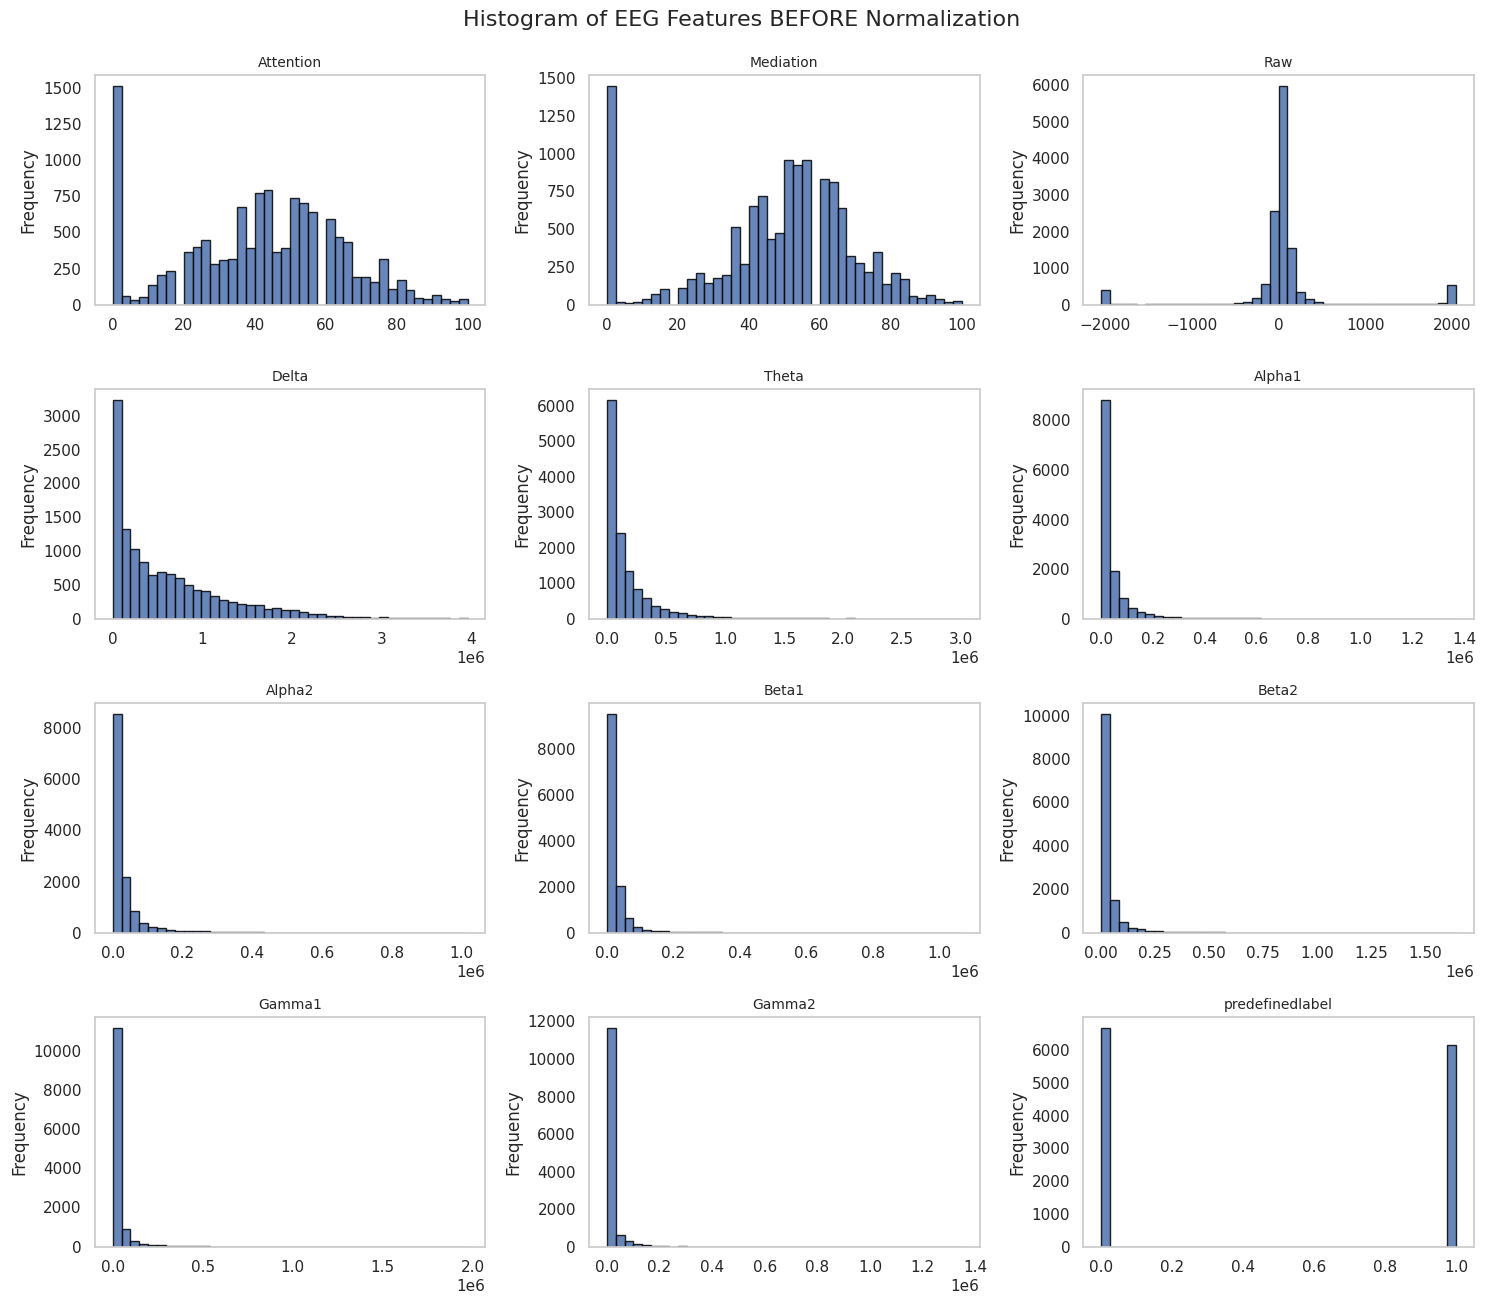

Applied MinMaxScaler to EEG feature columns.


In [4]:
eeg_df = pd.read_csv(EEG_CSV)
demo_df = pd.read_csv(DEMO_CSV) if os.path.exists(DEMO_CSV) else pd.DataFrame()

# normalize demo headers
if not demo_df.empty:
    demo_df.columns = demo_df.columns.str.strip().str.replace(' ', '').str.lower()

print('EEG rows:', len(eeg_df), 'Demo rows:', len(demo_df))
print('EEG columns:', eeg_df.columns.tolist())
print('Demo columns:', demo_df.columns.tolist())

# detect labels & features
GROUP_COLS = ['SubjectID', 'VideoID']
col_map = {}
for c in eeg_df.columns:
    low = c.lower().replace('-', '').replace('_','').replace(' ','')
    if 'predefinedlabel' in low:
        col_map['predefinedlabel'] = c
    if 'userdefinedlabeln' in low or 'userdefinedlabel' in low or 'userdefined' in low:
        col_map['user_defined'] = c

if 'predefinedlabel' not in col_map and 'user_defined' not in col_map:
    raise ValueError("Couldn't detect label column in EEG CSV. Check headers.")

LABEL_COL = col_map.get('user_defined', col_map.get('predefinedlabel'))
print('Using label col:', LABEL_COL)

# feature columns: drop groups and labels
exclude = set(GROUP_COLS) | {LABEL_COL}
FEATURE_COLS = [c for c in eeg_df.columns if c not in exclude]
print('FEATURE_COLS:', FEATURE_COLS)

n = len(FEATURE_COLS)
ncols = 3
nrows = math.ceil(n / ncols)
fig_w = 5 * ncols
fig_h = 3.5 * nrows
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h))
axes = axes.flatten()

for i, col in enumerate(FEATURE_COLS):
    ax = axes[i]
    # basic histogram;
    eeg_df[col].plot.hist(ax=ax, bins=40, edgecolor='black', alpha=0.85)
    ax.set_title(col, fontsize=10)
    ax.grid(False)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.suptitle('Histogram of EEG Features BEFORE Normalization', fontsize=16, y=0.96)
plt.show()

# Normalise EEG feature columns (MinMax scaling per column across dataset)
scaler = MinMaxScaler()
eeg_df[FEATURE_COLS] = scaler.fit_transform(eeg_df[FEATURE_COLS])
print("Applied MinMaxScaler to EEG feature columns.")

#Plot Waves

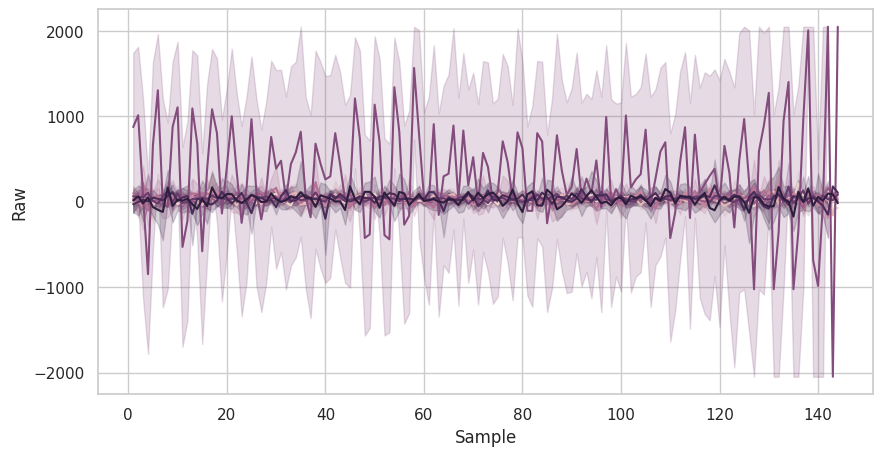

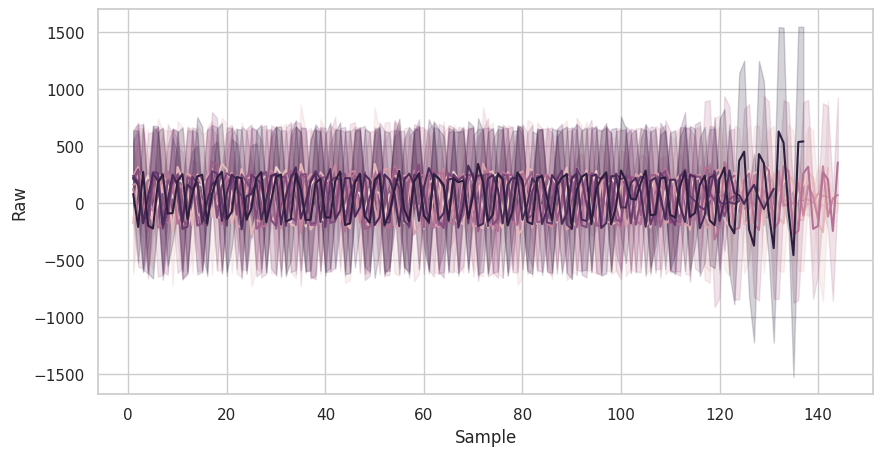

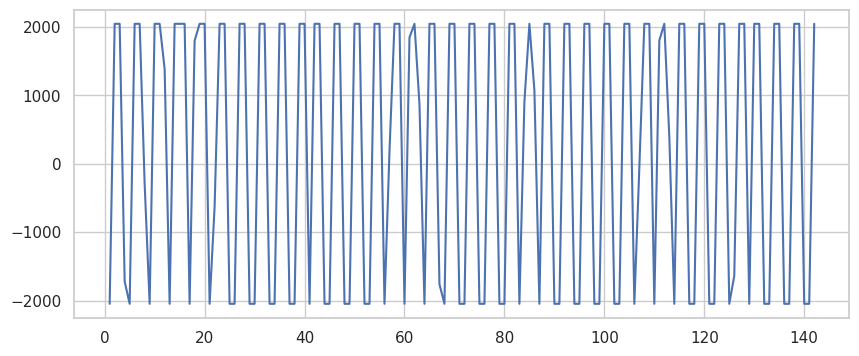

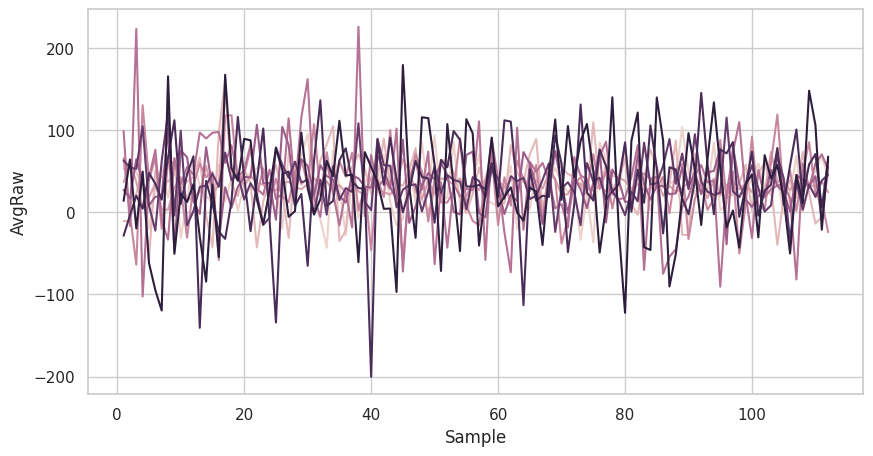

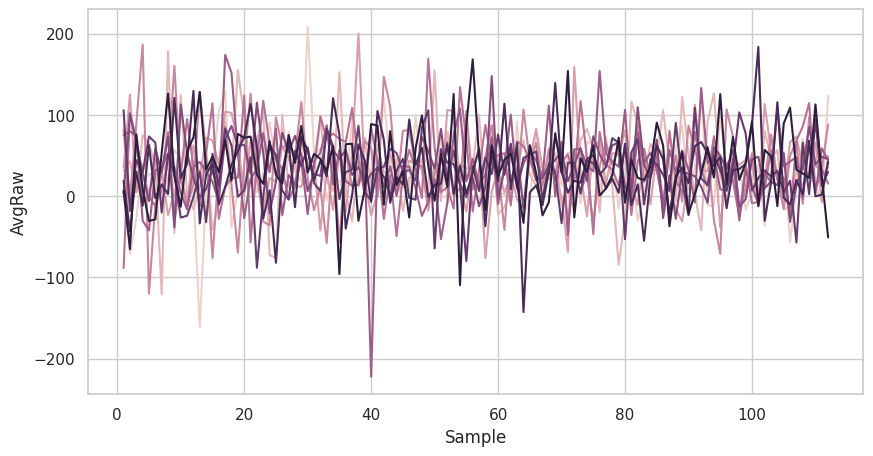

In [5]:
# Load packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
eeg = pd.read_csv('/content/EEG_data.csv')

# Add sample index per subject-video
eeg['Sample'] = eeg.groupby(['SubjectID', 'VideoID']).cumcount() + 1

# Quick overview plots
plt.figure(figsize=(10,5))
sns.lineplot(data=eeg, x="Sample", y="Raw", hue="SubjectID", legend=False)
plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=eeg, x="Sample", y="Raw", hue="VideoID", legend=False)
plt.show()

# Inspect each subject/video manually (optional)
# for i in eeg['SubjectID'].unique():
#     for j in eeg['VideoID'].unique():
#         df = eeg[(eeg['SubjectID'] == i) & (eeg['VideoID'] == j)]
#         plt.plot(df['Raw'])
#         plt.ylim(-200, 200)
#         plt.xlabel("Sample")
#         plt.ylabel("mV")
#         plt.title(f"Subject {i} Video {j}")
#         plt.show()

# Example: plot subject with noisy data
df_noisy = eeg[(eeg['SubjectID'] == 6) & (eeg['VideoID'] == 1)]
plt.figure(figsize=(10,4))
plt.plot(df_noisy['Sample'], df_noisy['Raw'])
plt.show()

# Remove noisy subject
eeg_clean = eeg[eeg['SubjectID'] != 6]

# Count samples per subject-video
eeg_len = (
    eeg_clean.groupby(['SubjectID', 'VideoID'])['Sample']
    .max()
    .reset_index(name='MaxSamples')
)

# Find minimum sample length
shortestSample = eeg_len['MaxSamples'].min()

# Cut samples to equal length
eeg_clean_cut = eeg_clean[eeg_clean['Sample'] <= shortestSample]

# Grand averages
subject_GA = (
    eeg_clean_cut.groupby(['SubjectID', 'Sample'])['Raw']
    .mean()
    .reset_index(name='AvgRaw')
)

video_GA = (
    eeg_clean_cut.groupby(['VideoID', 'Sample'])['Raw']
    .mean()
    .reset_index(name='AvgRaw')
)

# Plot subject grand averages
plt.figure(figsize=(10,5))
sns.lineplot(data=subject_GA, x="Sample", y="AvgRaw", hue="SubjectID", legend=False)
plt.show()

# Plot video grand averages
plt.figure(figsize=(10,5))
sns.lineplot(data=video_GA, x="Sample", y="AvgRaw", hue="VideoID", legend=False)
plt.show()


#Plots: Histogram and Heatmap

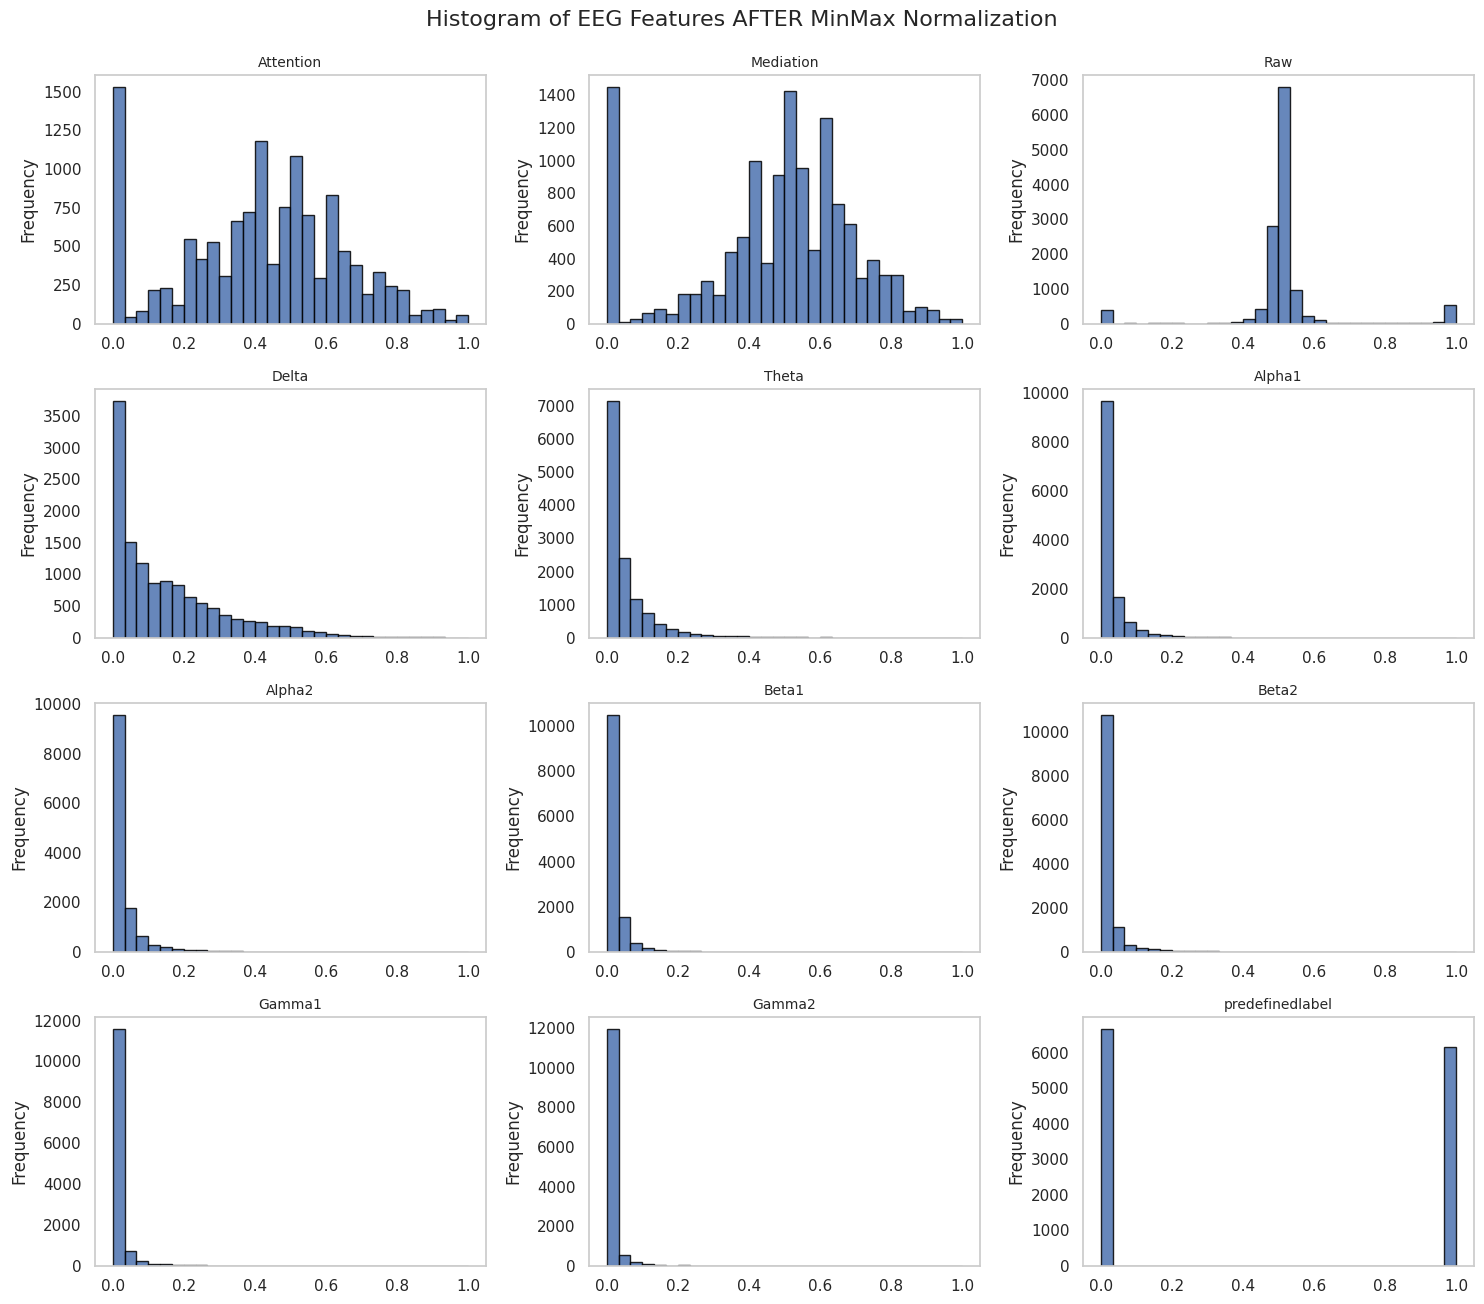

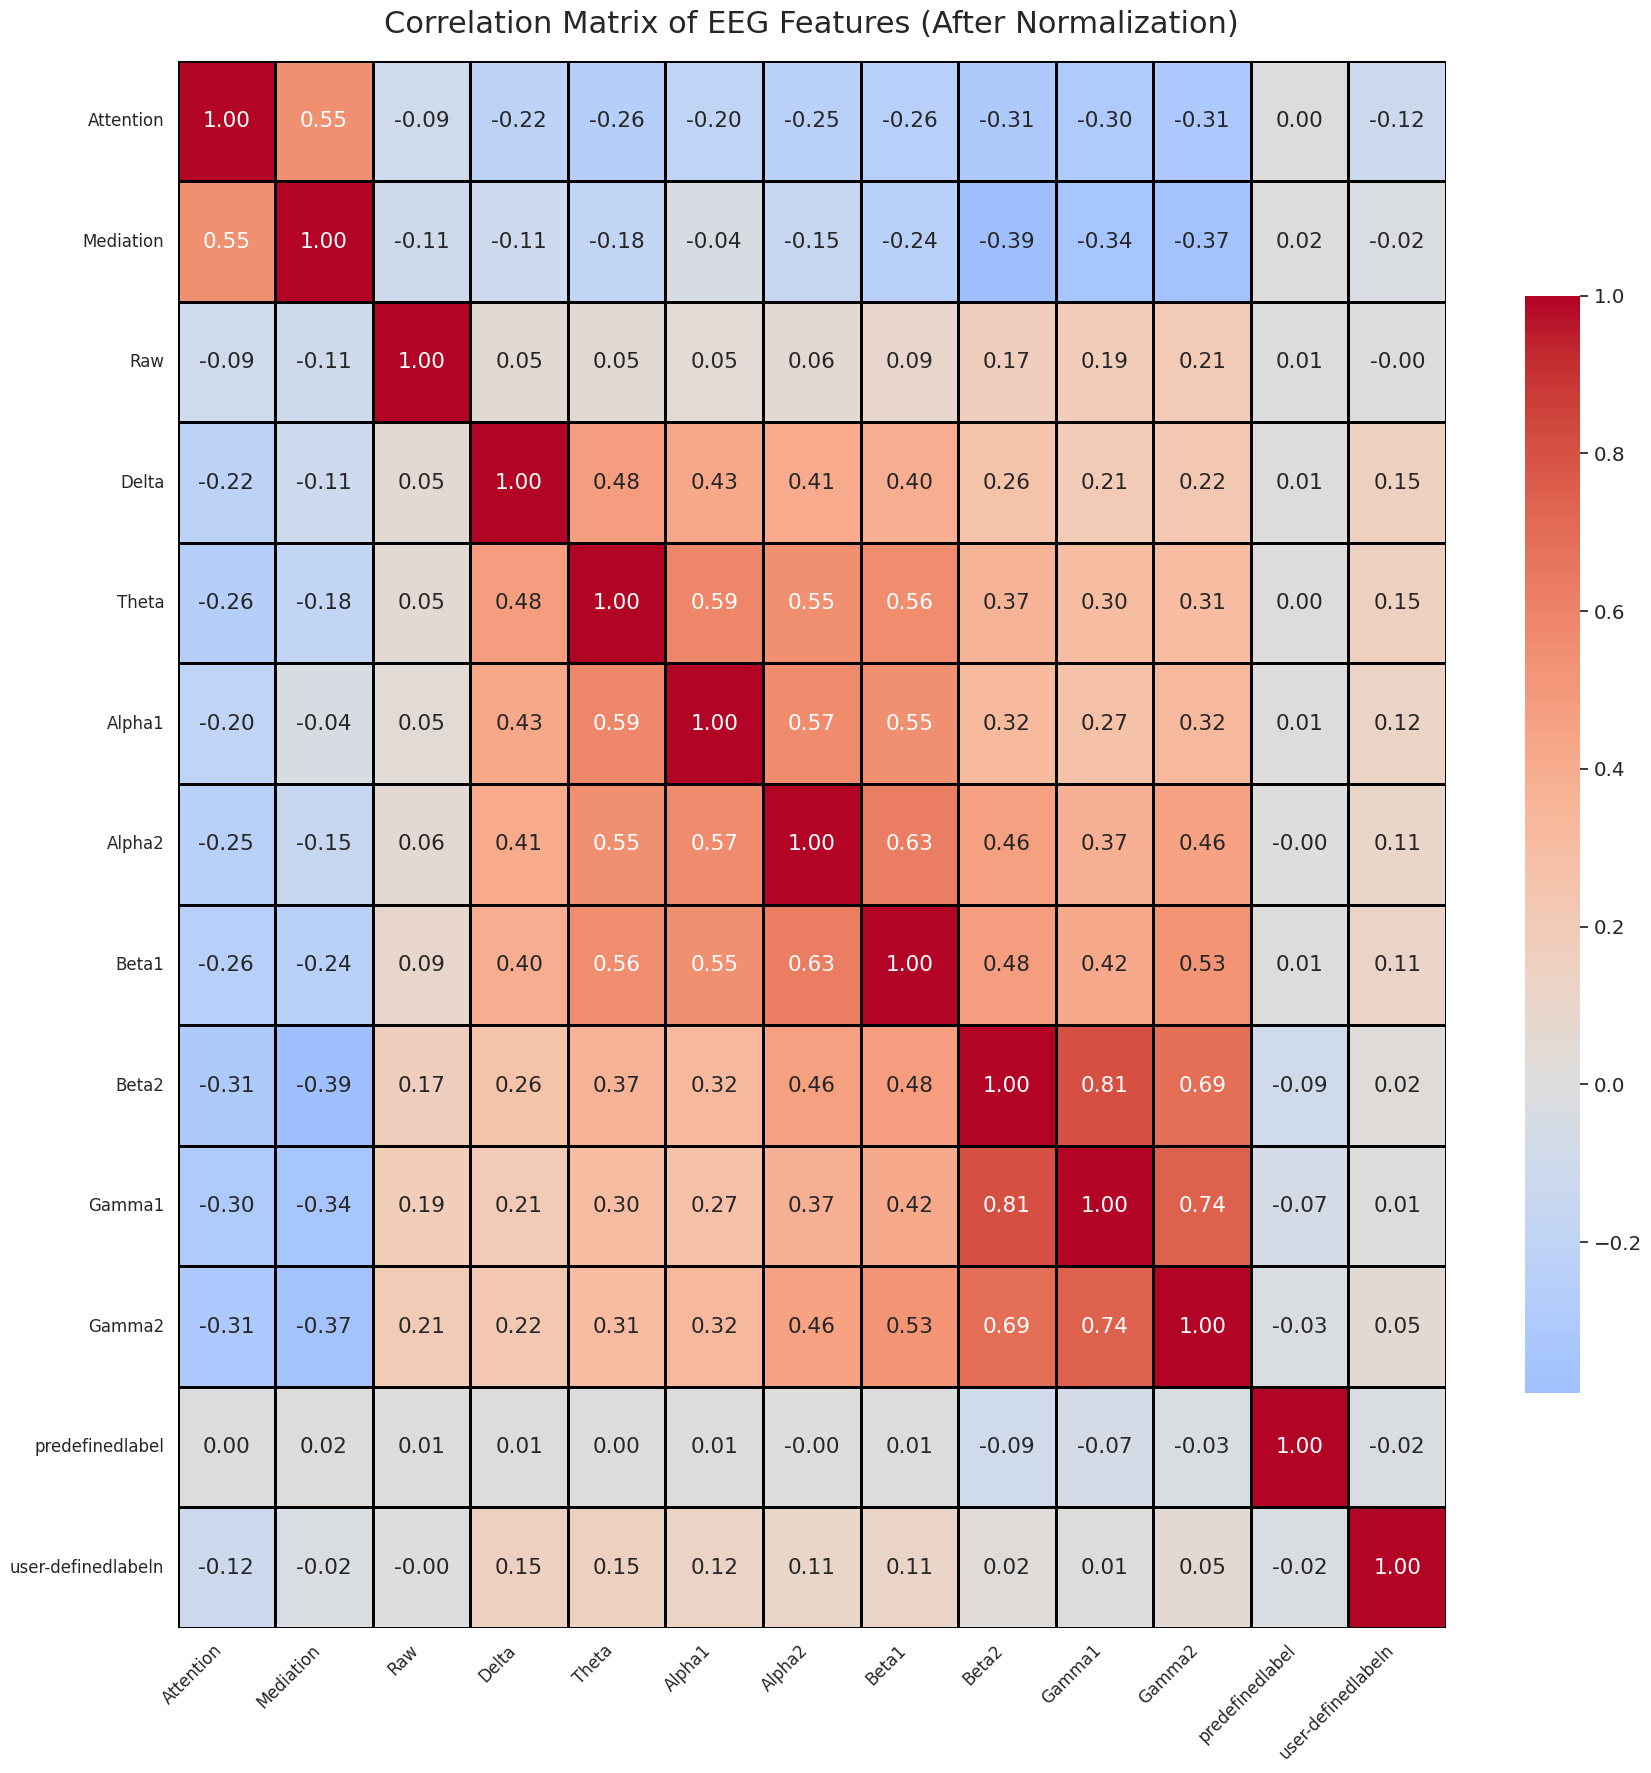

In [6]:
#Histogram
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h))
axes = axes.flatten()
for i, col in enumerate(FEATURE_COLS):
    ax = axes[i]
    eeg_df[col].plot.hist(ax=ax, bins=30, edgecolor='black', alpha=0.85)
    ax.set_title(col, fontsize=10)
    ax.grid(False)
for j in range(i+1, len(axes)):
    axes[j].axis('off')
plt.tight_layout(rect=[0, 0.03, 1, 0.94])
plt.suptitle('Histogram of EEG Features AFTER MinMax Normalization', fontsize=16, y=0.96)
plt.show()

#Correlation Heatmap
cor_matrix = pd.concat(
    (eeg_df[FEATURE_COLS], eeg_df[[LABEL_COL]]),
    axis=1
).corr()

plt.figure(figsize=(18, 18))

sns.set(font_scale=1.3)

sns.heatmap(
    cor_matrix,
    annot=True,
    cmap="coolwarm",
    center=0,
    fmt=".2f",
    linewidths=1.0,
    linecolor='black',
    cbar_kws={"shrink": 0.7}
)

plt.title("Correlation Matrix of EEG Features (After Normalization)", fontsize=22, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.tight_layout()
plt.show()

#Trials, Demo Vectors

In [7]:
sample_dict = OrderedDict()
labels_user = {}

for (sub, vid), g in eeg_df.groupby(GROUP_COLS):
    # original per-trial array (T_raw, n_features)
    arr = g[FEATURE_COLS].values.astype(np.float32)
    arr = resample_to_fixed_np(arr, T_target=ORIG_T)  # keep full-trial length first

    # Sliding window through the resampled full-trial
    T_full = arr.shape[0]
    win_idx = 0
    for start in range(0, max(1, T_full - WINDOW_SIZE + 1), WINDOW_STRIDE):
        end = start + WINDOW_SIZE
        window = arr[start:end]

        # If window length is not exactly WINDOW_SIZE,
        # resample/pad/truncate to T_TARGET
        if window.shape[0] != WINDOW_SIZE:
            window = resample_to_fixed_np(window, T_target=T_TARGET)
        else:
            window = window.astype(np.float32)

        # normalize subject id to int if possible (unchanged)
        try:
            sub_key = int(sub)
        except Exception:
            try:
                sub_key = int(float(sub))
            except Exception:
                sub_key = sub

        # store sample with window index so keys are unique:
        key = (sub_key, str(vid), win_idx)
        sample_dict[key] = window
        # copy label per-sample (same as trial label)
        labels_user[key] = g[LABEL_COL].iloc[0]

        win_idx += 1

print("Built samples:", len(sample_dict), "example key:", next(iter(sample_dict.keys())))


Built samples: 1000 example key: (0, '0.0', 0)


In [8]:
if not demo_df.empty:
    # index by subjectid if possible
    if 'subjectid' in demo_df.columns:
        demo_df = demo_df.set_index('subjectid')

# detect categorical columns
demo_cat_cols = [c for c in ['ethnicity', 'gender'] if c in demo_df.columns]

if demo_df.empty or len(demo_cat_cols) == 0:
    # fallback dummy vector
    unique_subjects = sorted(eeg_df['SubjectID'].unique().astype(int))
    demo_onehot = pd.DataFrame(
        0.0,
        index=unique_subjects,
        columns=['demo_dummy']
    )
else:
    # one-hot encode categorical demo info
    demo_onehot = pd.get_dummies(demo_df[demo_cat_cols].fillna('Unknown'))

    # normalize age if available
    if 'age' in demo_df.columns:
        demo_onehot['age'] = (
            (demo_df['age'] - demo_df['age'].mean()) /
            (demo_df['age'].std() + 1e-8)
        )

    # ensure index is integer subjects
    try:
        demo_onehot.index = demo_onehot.index.astype(int)
    except:
        pass

print("demo_onehot.shape =", demo_onehot.shape)

demo_onehot.shape = (10, 6)


#Exploratory Data Analysis

trials_df: (1000, 16)


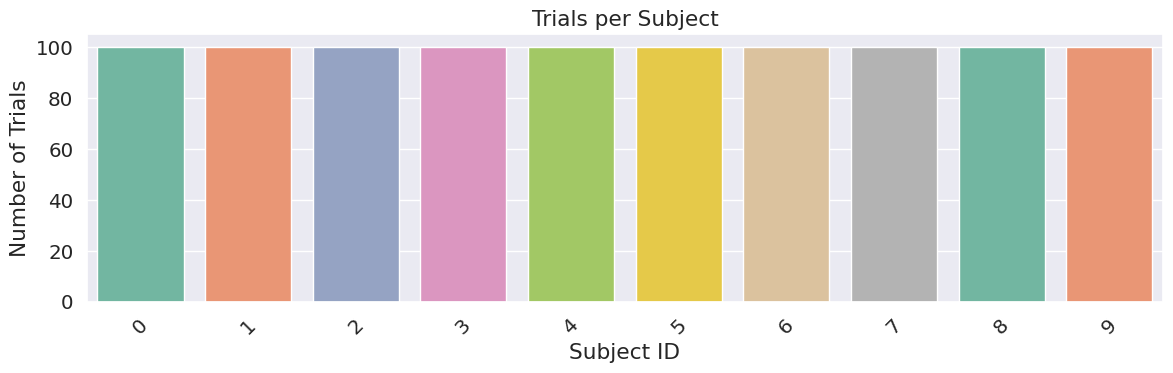

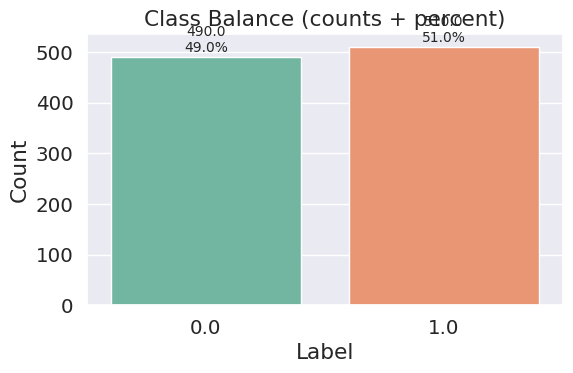

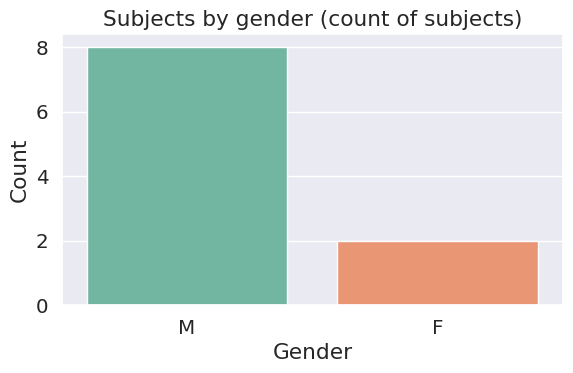

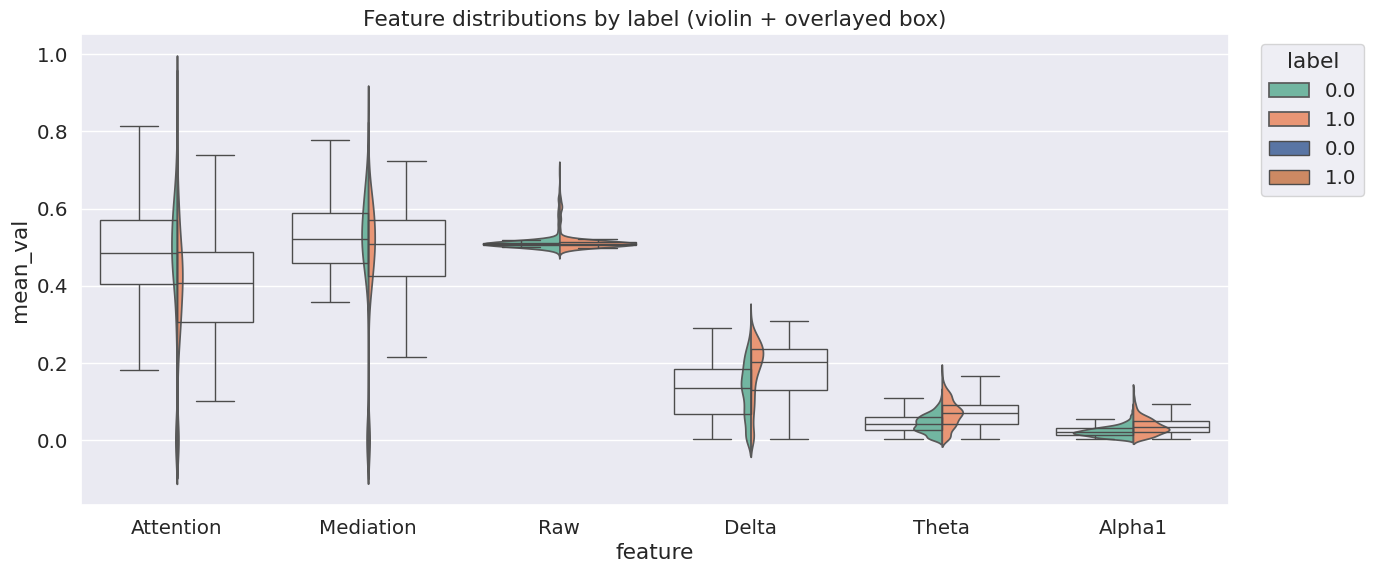

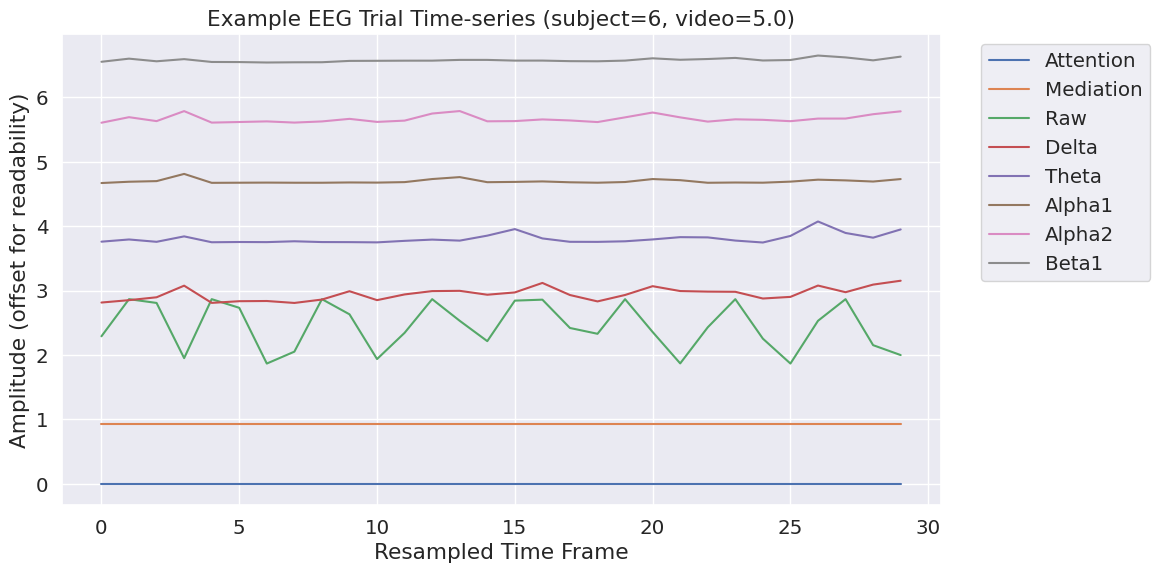

In [9]:
# one-row-per-trial summary table (mean of each EEG feature per trial)
rows = []
for (sub, vid, win_idx), arr in sample_dict.items():
    mean_feats = arr.mean(axis=0)
    row = {
        'subject': sub,
        'video': vid,
        'win_idx': win_idx,
        'label': labels_user[(sub, vid, win_idx)]
    }
    for i, feat in enumerate(FEATURE_COLS):
        row[feat] = float(mean_feats[i])
    rows.append(row)

trials_df = pd.DataFrame(rows)
print("trials_df:", trials_df.shape)
palette = sns.color_palette("Set2")

# Trials per subject
plt.figure(figsize=(12,4))
counts = trials_df['subject'].value_counts().sort_index()
sns.barplot(x=counts.index.astype(str), y=counts.values, palette=palette)
plt.xlabel("Subject ID")
plt.ylabel("Number of Trials")
plt.title("Trials per Subject")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Class balance (counts + percent)
plt.figure(figsize=(6,4))
ax = sns.countplot(x='label', data=trials_df, palette=palette)
tot = len(trials_df)
for p in ax.patches:
    h = p.get_height()
    ax.text(p.get_x() + p.get_width()/2, h + max(1, tot*0.01),
            f"{h}\n{h/tot:.1%}", ha='center', fontsize=10)
plt.title("Class Balance (counts + percent)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Demographics / Gender plotting
gender_col = None
g_cols = [c for c in demo_onehot.columns if c.lower().startswith('gender')]
if len(g_cols) > 0:
    gender_series = demo_onehot[g_cols].idxmax(axis=1).str.replace('gender_', '', regex=False)
    gender_series.name = 'gender'
    gender_col = gender_series
elif 'gender' in demo_onehot.columns:
    gender_col = demo_onehot['gender']

if gender_col is not None:
    # map subjects present in trials_df
    subj_gender = gender_col.loc[trials_df['subject'].unique()].value_counts()
    plt.figure(figsize=(6,4))
    sns.barplot(x=subj_gender.index.astype(str), y=subj_gender.values, palette=palette)
    plt.title("Subjects by gender (count of subjects)")
    plt.ylabel("Count")
    plt.xlabel("Gender")
    plt.tight_layout()
    plt.show()
else:
    print("No explicit 'gender' one-hot found in demo_onehot; skip gender plot.")

# Violin + box combo for features grouped by label
show_feats = FEATURE_COLS[:6]
melt = trials_df.melt(id_vars=['subject','video','label'], value_vars=show_feats,
                      var_name='feature', value_name='mean_val')
plt.figure(figsize=(14,6))
sns.violinplot(x='feature', y='mean_val', hue='label', data=melt, split=True, inner=None, palette='Set2')
sns.boxplot(x='feature', y='mean_val', hue='label', data=melt, showcaps=True,
            boxprops={'facecolor':'none'}, showfliers=False, whiskerprops={'linewidth':1})
plt.title("Feature distributions by label (violin + overlayed box)")
plt.legend(title='label', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ---------- 8) Example EEG trial time-series ----------
import random
sub_vid = random.choice(list(sample_dict.keys()))
arr = sample_dict[sub_vid]   # shape (T, C)
t = np.arange(arr.shape[0])
plt.figure(figsize=(12,6))
nplot = min(8, arr.shape[1])              # plot up to 8 channels
offset = arr.std() * 3.0                  # smart offset scale (array of shape (T,C) so std -> array; take mean)
for i in range(nplot):
    plt.plot(t, arr[:, i] + i*offset.mean(), label=FEATURE_COLS[i])
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1.0))
plt.title(f"Example EEG Trial Time-series (subject={sub_vid[0]}, video={sub_vid[1]})")
plt.xlabel("Resampled Time Frame")
plt.ylabel("Amplitude (offset for readability)")
plt.tight_layout()
plt.show()

#Video Embeddings

In [10]:
VIDEO_EMB_DIR = os.path.join(OUT_DIR, 'video_embeddings')
os.makedirs(VIDEO_EMB_DIR, exist_ok=True)

video_ids = sorted({
    str(int(float(vid))) if str(vid).replace('.0','').isdigit() else str(vid)
    for (_, vid, *_) in sample_dict.keys()
})
print('video ids:', video_ids)

# init resnet (catch internet / weight issues)
try:
    resnet = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')
    preprocess = keras.applications.resnet50.preprocess_input
    USE_RESNET = True
except Exception as e:
    print('ResNet init failed:', e)
    USE_RESNET = False
    resnet = None
    preprocess = lambda x: x

video_emb_dict = {}
NUM_EXTRACT_FRAMES = 5   # <-- use 3–5 real frames for hybrid model

for vid in video_ids:
    out_path = os.path.join(VIDEO_EMB_DIR, f'{vid}.npy')

    if os.path.exists(out_path):
        video_emb_dict[vid] = np.load(out_path)
        continue

    # find candidate video files
    matches = []
    for ext in ['mp4','m4v','mov','avi','mkv']:
        p = os.path.join(VIDEOS_DIR, f"{vid}.{ext}")
        if os.path.exists(p):
            matches.append(p)
    if not matches:
        g = glob.glob(os.path.join(VIDEOS_DIR, f"{vid}.*"))
        matches = g

    if not matches:
        dim = 2048 if not USE_RESNET else resnet.output_shape[-1]
        zero_seq = np.zeros((NUM_EXTRACT_FRAMES, dim), dtype=np.float32)
        video_emb_dict[vid] = zero_seq
        np.save(out_path, zero_seq)
        continue

    video_file = matches[0]

    def extract_frames(path, num_frames=NUM_EXTRACT_FRAMES,
                       start_sec=2, duration=10):

        cap = cv2.VideoCapture(path)
        if not cap.isOpened():
            return []

        fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
        total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0)

        start_frame = int(start_sec * fps)
        end_frame   = int(min(total - 1, (start_sec + duration) * fps))

        # fallback if invalid
        if end_frame <= start_frame:
            start_frame = 0
            end_frame = max(total - 1, 0)

        if total <= 0:
            idxs = np.linspace(0, max(total - 1, 0), num_frames).astype(int)
        else:
            idxs = np.linspace(start_frame, end_frame, num_frames).astype(int)

        frames = []
        for fi in idxs:
            cap.set(cv2.CAP_PROP_POS_FRAMES, int(fi))
            ret, frame = cap.read()
            if not ret or frame is None:
                continue
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = cv2.resize(frame, IMG_SIZE)
            frames.append(frame)

        cap.release()
        return frames

    frames = extract_frames(video_file)

    if len(frames) == 0:
        dim = 2048 if not USE_RESNET else resnet.output_shape[-1]
        zero_seq = np.zeros((NUM_EXTRACT_FRAMES, dim), dtype=np.float32)
        video_emb_dict[vid] = zero_seq
        np.save(out_path, zero_seq)
        continue

    # preprocess each frame, pass through ResNet
    x = np.stack(frames).astype(np.float32)
    x = preprocess(x)
    emb_seq = resnet.predict(x, verbose=0)   # shape: (num_frames, 2048)

    np.save(out_path, emb_seq)
    video_emb_dict[vid] = emb_seq

# final: video_dim = 2048 but video_emb_dict[vid].shape = (NUM_FRAMES, 2048)
video_dim = video_emb_dict[video_ids[0]].shape[1]
print('video_dim:', video_dim)


video ids: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
video_dim: 2048


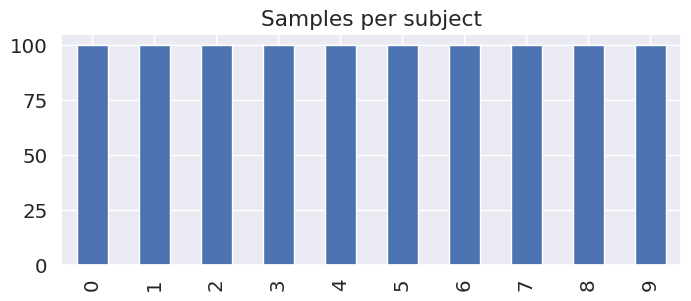

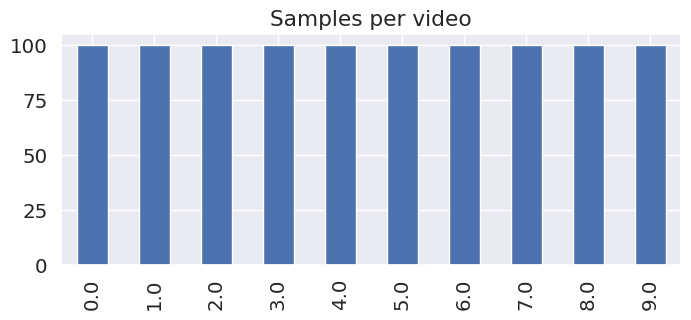

In [11]:
# sample counts per subject/video
from collections import Counter
subs = [k[0] for k in sample_dict.keys()]
vids = [k[1] for k in sample_dict.keys()]
plt.figure(figsize=(8,3))
pd.Series(subs).value_counts().sort_index().plot(kind='bar', title='Samples per subject'); plt.show()
plt.figure(figsize=(8,3))
pd.Series(vids).value_counts().plot(kind='bar', title='Samples per video'); plt.show()

#Build Dataset

In [12]:
def eeg_to_image(arr, out_size=(224,224)):
    img = arr.T  # (C, T)

    mn = img.min(axis=1, keepdims=True)
    mx = img.max(axis=1, keepdims=True)
    denom = (mx - mn)
    denom[denom == 0] = 1.0
    img = (img - mn) / denom

    img = img.astype(np.float32)
    img = np.expand_dims(img, -1)
    img = tf.image.resize(img, out_size, method='bilinear').numpy()

    img = np.repeat(img, 3, axis=-1)

    return img

EEG_IMG_DIR = os.path.join(OUT_DIR, "eeg_images")
os.makedirs(EEG_IMG_DIR, exist_ok=True)

eeg_image_dict = {}

print("Precomputing EEG images...")
for k, arr in sample_dict.items():
    out_path = os.path.join(EEG_IMG_DIR, f"{k}.npy")
    out_path = out_path.replace("(", "").replace(")", "").replace(",", "_").replace(" ", "")

    if os.path.exists(out_path):
        eeg_image_dict[k] = np.load(out_path)
    else:
        img = eeg_to_image(arr, out_size=IMG_SIZE)
        np.save(out_path, img)
        eeg_image_dict[k] = img
print("Done precomputing EEG images.")

def augment_eeg(arr):
    """Simple augmentation: gaussian noise, channel dropout, time masking."""
    a = arr.copy()
    # gaussian noise
    a = a + np.random.normal(0, 0.01, a.shape).astype(np.float32)
    # channel dropout
    if np.random.rand() < 0.2:
        ci = np.random.randint(0, a.shape[1])
        a[:, ci] = 0
    # time masking
    if np.random.rand() < 0.2:
        t = a.shape[0]
        w = int(t * 0.1)
        if w > 0:
            s = np.random.randint(0, t - w + 1)
            a[s:s+w, :] = 0
    return a

def build_dataset_from_keys(keys, model_type='base',
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            n_frames=NUM_FRAMES_FOR_VIDEO,
                            augment=False):
    eeg_list, video_list, vseq_list, eegimg_list, demo_list, labels = [], [], [], [], [], []
    for k in keys:
        # support both (sub, vid) and (sub, vid, window_idx)
        if len(k) == 3:
            sub, vid, _ = k
        else:
            sub, vid = k

        arr = sample_dict[k].astype(np.float32)

        # augmentation only when requested + enabled
        if augment and USE_AUGMENTATION:
            arr = augment_eeg(arr)

        # per-trial z-score
        mean = arr.mean(axis=0, keepdims=True)
        std = arr.std(axis=0, keepdims=True) + 1e-8
        arr = (arr - mean) / std
        eeg_list.append(arr)

        # video embedding
        try:
            vid_norm = str(int(float(vid)))
        except Exception:
            vid_norm = str(vid)

        v_raw = video_emb_dict.get(vid_norm, None)

        # fallback if missing
        if v_raw is None:
            # default: zero sequence of length n_frames
            v_raw = np.zeros((n_frames, video_dim), dtype=np.float32)

        v_raw = np.array(v_raw)

        # handle 1D vs 2D
        if v_raw.ndim == 1:
            # shape: (video_dim,)
            v_mean = v_raw
            # build sequence by tiling
            vseq = np.tile(v_raw[None, :], (n_frames, 1))
        elif v_raw.ndim == 2:
            # shape: (F, video_dim)  -> real frames
            if v_raw.shape[0] == 0:
                v_raw = np.zeros((n_frames, video_dim), dtype=np.float32)

            # mean embedding for base/transfer
            v_mean = v_raw.mean(axis=0)

            # sequence for hybrid
            vseq = v_raw
            # pad / trim to n_frames
            if vseq.shape[0] < n_frames:
                pad_len = n_frames - vseq.shape[0]
                pad = np.zeros((pad_len, vseq.shape[1]), dtype=np.float32)
                vseq = np.concatenate([vseq, pad], axis=0)
            elif vseq.shape[0] > n_frames:
                idx = np.linspace(0, vseq.shape[0] - 1, n_frames).astype(int)
                vseq = vseq[idx]
        else:
            # weird shape, fallback to zeros
            v_mean = np.zeros((video_dim,), dtype=np.float32)
            vseq = np.zeros((n_frames, video_dim), dtype=np.float32)

        video_list.append(v_mean.astype(np.float32))
        vseq_list.append(vseq.astype(np.float32))

        # EEG → image for transfer model
        eegimg_list.append(eeg_image_dict[k])

        # demo
        if sub in demo_onehot.index:
            demo_list.append(demo_onehot.loc[sub].values.astype(np.float32))
        else:
            demo_list.append(np.zeros((demo_onehot.shape[1],), dtype=np.float32))

        labels.append(labels_user[k])

    eeg_arr    = np.stack(eeg_list).astype(np.float32)
    video_arr  = np.stack(video_list).astype(np.float32)   # (N, video_dim)
    vseq_arr   = np.stack(vseq_list).astype(np.float32)    # (N, n_frames, video_dim)
    eegimg_arr = np.stack(eegimg_list).astype(np.float32)
    demo_arr   = np.stack(demo_list).astype(np.float32)
    y          = np.array(labels).astype(np.float32)

    if model_type == 'base':
        ds = tf.data.Dataset.from_tensor_slices(((eeg_arr, video_arr, demo_arr), y))
    elif model_type == 'hybrid':
        ds = tf.data.Dataset.from_tensor_slices(((eeg_arr, vseq_arr, demo_arr), y))
    else:  # transfer
        ds = tf.data.Dataset.from_tensor_slices(((eegimg_arr, video_arr, demo_arr), y))

    if shuffle:
        ds = ds.shuffle(256, seed=SEED)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


Precomputing EEG images...
Done precomputing EEG images.


#Base Model

In [15]:
def build_base_model(T=T_TARGET, C=len(FEATURE_COLS), video_dim=video_dim, demo_dim=demo_onehot.shape[1]):
    # EEG branch: TCN / 1D CNN stack
    eeg_in = layers.Input(shape=(T, C), name='eeg_input')
    x = layers.Conv1D(64, kernel_size=7, padding='same', activation='relu')(eeg_in)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    # simple residual TCN-style blocks
    for filters in [64, 128]:
        shortcut = x
        x = layers.Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Conv1D(filters, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.BatchNormalization()(x)
        # match channels for residual if needed
        if shortcut.shape[-1] != x.shape[-1]:
            shortcut = layers.Conv1D(filters, kernel_size=1, padding='same')(shortcut)
        x = layers.Add()([shortcut, x])
        x = layers.MaxPooling1D(pool_size=2)(x)
        x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling1D()(x)
    eeg_feat = layers.Dense(128, activation='relu',
                            kernel_regularizer=keras.regularizers.l2(1e-4))(x)

    # Video branch (unchanged)
    video_in = layers.Input(shape=(video_dim,), name='video_input')
    v = layers.Dense(256, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-4))(video_in)
    v = layers.Dropout(0.3)(v)
    video_feat = layers.Dense(128, activation='relu')(v)

    # Demo branch (unchanged)
    demo_in = layers.Input(shape=(demo_dim,), name='demo_input')
    d = layers.Dense(64, activation='relu')(demo_in)
    demo_feat = layers.Dense(32, activation='relu')(d)

    # Fusion + head
    fused = layers.Concatenate()([eeg_feat, video_feat, demo_feat])
    x = layers.Dense(256, activation='relu')(fused)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid', name='prob')(x)

    model = keras.Model([eeg_in, video_in, demo_in], out, name='base_model')
    model.compile(
        optimizer=keras.optimizers.Adam(1e-4),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )
    return model

#Hybrid Model

In [16]:
def inception_block_1d(x, filters=32):
    conv1 = layers.Conv1D(filters, 1, padding='same', activation='relu')(x)
    conv3 = layers.Conv1D(filters, 3, padding='same', activation='relu')(x)
    conv5 = layers.Conv1D(filters, 5, padding='same', activation='relu')(x)
    pool = layers.MaxPooling1D(3, padding='same', strides=1)(x)
    pool = layers.Conv1D(filters, 1, padding='same', activation='relu')(pool)
    return layers.Concatenate()([conv1, conv3, conv5, pool])

def build_hybrid_model(T=T_TARGET, C=len(FEATURE_COLS), video_dim=video_dim,
                       demo_dim=demo_onehot.shape[1], n_frames=NUM_FRAMES_FOR_VIDEO):
    # EEG branch (same as before)
    eeg_in = layers.Input((T, C), name='eeg_input')
    x = layers.Conv1D(64, 3, padding='same', activation='relu')(eeg_in)
    for _ in range(2):
        x = inception_block_1d(x, filters=32)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling1D(2, padding='same')(x)
    eeg_seq = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
    eeg_pooled = layers.GlobalAveragePooling1D()(eeg_seq)
    eeg_proj = layers.Dense(128, activation='relu')(eeg_pooled)

    # Video branch: Transformer-style encoder
    video_seq_in = layers.Input((n_frames, video_dim), name='video_seq_input')
    v = layers.Dense(128, activation='relu')(video_seq_in)  # frame-wise projection

    # simple learnable positional encoding
    pos_emb = layers.Embedding(input_dim=n_frames, output_dim=128)(
        tf.range(start=0, limit=n_frames, delta=1)
    )
    pos_emb = tf.cast(pos_emb, tf.float32)
    pos_emb = tf.expand_dims(pos_emb, axis=0)  # (1, n_frames, 128)
    v = v + pos_emb

    # Transformer-style self-attention block
    attn_out = layers.MultiHeadAttention(num_heads=4, key_dim=32)(v, v)
    v = layers.Add()([v, attn_out])
    v = layers.LayerNormalization()(v)
    ff = layers.Dense(256, activation='relu')(v)
    ff = layers.Dense(128)(ff)
    v = layers.Add()([v, ff])
    v = layers.LayerNormalization()(v)

    v_pool = layers.GlobalAveragePooling1D()(v)
    video_proj = layers.Dense(128, activation='relu')(v_pool)

    # Cross-attention: EEG as query, video sequence as key/value
    q = layers.Reshape((1, 128))(layers.Dense(128)(eeg_proj))
    cross_att = layers.MultiHeadAttention(num_heads=4, key_dim=32)(q, v)
    cross_att = layers.Reshape((cross_att.shape[-1],))(cross_att)

    # Demo branch
    demo_in = layers.Input((demo_dim,), name='demo_input')
    demo_proj = layers.Dense(32, activation='relu')(demo_in)

    # Fusion + head
    fused = layers.Concatenate()([eeg_proj, video_proj, cross_att, demo_proj])
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=keras.regularizers.l2(1e-4))(fused)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid', name='prob')(x)

    model = keras.Model([eeg_in, video_seq_in, demo_in], out, name='hybrid_model')
    model.compile(
        optimizer=keras.optimizers.Adam(2e-4),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )
    return model

#Transfer Learning

In [13]:
def build_transfer_model(image_size=(224,224,3), video_dim=video_dim, demo_dim=demo_onehot.shape[1], freeze_backbone=True):
    eeg_img_in = layers.Input(shape=image_size, name='eeg_img_input')
    base_eeg = keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg')
    if freeze_backbone:
        for layer in base_eeg.layers[:-10]:
            layer.trainable = False
    eeg_feat = base_eeg(eeg_img_in)
    eeg_proj = layers.Dense(256, activation='relu')(eeg_feat)
    eeg_proj = layers.Dropout(0.3)(eeg_proj)

    video_in = layers.Input(shape=(video_dim,), name='video_input')
    v = layers.Dense(512, activation='relu')(video_in)
    v = layers.Dropout(0.3)(v)
    video_proj = layers.Dense(256, activation='relu')(v)

    demo_in = layers.Input(shape=(demo_dim,), name='demo_input')
    d = layers.Dense(64, activation='relu')(demo_in)
    d = layers.Dense(32, activation='relu')(d)

    fused = layers.Concatenate()([eeg_proj, video_proj, d])
    x = layers.Dense(256, activation='relu')(fused)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(1, activation='sigmoid', name='prob')(x)

    model = keras.Model([eeg_img_in, video_in, demo_in], out, name='transfer_model')
    model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model

#LOSO Training Wrapper and Helpers

In [14]:
def build_aggregated_features_dict(sample_dict, FEATURE_COLS):
    keys = list(sample_dict.keys())
    feats = []
    for k in keys:
        arr = sample_dict[k]
        mean = arr.mean(axis=0)
        std = arr.std(axis=0)
        q25 = np.percentile(arr, 25, axis=0)
        q50 = np.percentile(arr, 50, axis=0)
        q75 = np.percentile(arr, 75, axis=0)

        feat = np.concatenate([mean, std, q25, q50, q75])
        feats.append(feat)

    X = np.stack(feats)
    return keys, X

In [15]:
agg_keys, X_agg_all = build_aggregated_features_dict(sample_dict, FEATURE_COLS)
y_agg_all = np.array([labels_user[k] for k in agg_keys])

In [16]:
def train_xgb_on_keys(train_keys, val_keys):
    key_to_idx = {k:i for i,k in enumerate(agg_keys)}
    train_idx = [key_to_idx[k] for k in train_keys]
    val_idx   = [key_to_idx[k] for k in val_keys]

    X_train = X_agg_all[train_idx]
    y_train = y_agg_all[train_idx]
    X_val   = X_agg_all[val_idx]
    y_val   = y_agg_all[val_idx]

    clf = xgb.XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        eval_metric='logloss',
        random_state=42
    )

    clf.fit(X_train, y_train)
    p_val = clf.predict_proba(X_val)[:,1]
    return clf, p_val

In [17]:
def run_loso(model_type='base', epochs=EPOCHS):
    all_keys = list(sample_dict.keys())
    subjects = np.array([k[0] for k in all_keys])
    labels_arr = np.array([labels_user[k] for k in all_keys])
    unique_subjects = np.unique(subjects)
    gkf = GroupKFold(n_splits=len(unique_subjects))

    ENSEMBLE_WITH_XGB = True
    XGB_ENSEMBLE_WEIGHT = 0.4

    agg_keys = list(sample_dict.keys())
    agg_feats = []
    for k in agg_keys:
        arr = sample_dict[k]
        mean = arr.mean(axis=0)
        std = arr.std(axis=0)
        q25 = np.percentile(arr, 25, axis=0)
        q50 = np.percentile(arr, 50, axis=0)
        q75 = np.percentile(arr, 75, axis=0)
        feat = np.concatenate([mean, std, q25, q50, q75])
        agg_feats.append(feat)
    X_agg_all = np.stack(agg_feats)
    y_agg_all = np.array([labels_user[k] for k in agg_keys])
    key_to_idx = {k: i for i, k in enumerate(agg_keys)}

    results = []
    fold = 0
    for train_idx, val_idx in gkf.split(all_keys, labels_arr, groups=subjects):
        left_out_subjects = sorted(np.unique(subjects[val_idx]))
        print(f"\n--- Fold {fold} (left-out subject(s): {left_out_subjects}) ---")

        train_keys = [all_keys[i] for i in train_idx]
        val_keys   = [all_keys[i] for i in val_idx]

        y_train = np.array([labels_user[k] for k in train_keys])
        classes = np.unique(y_train)
        if len(classes) == 0:
            class_weight_map = None
        else:
            cw_vals = compute_class_weight('balanced', classes=classes, y=y_train)
            class_weight_map = {int(classes[i]): float(cw_vals[i]) for i in range(len(classes))}

        ds_train = build_dataset_from_keys(
            train_keys, model_type=model_type,
            batch_size=BATCH_SIZE, shuffle=True,
            augment=True
        )
        ds_val   = build_dataset_from_keys(
            val_keys, model_type=model_type,
            batch_size=BATCH_SIZE, shuffle=False,
            augment=False
        )

        EEG_T = T_TARGET
        EEG_C = len(FEATURE_COLS)
        VIDEO_DIM = video_dim
        DEMO_DIM = demo_onehot.shape[1]

        if model_type == 'base':
            model = build_base_model(T=EEG_T, C=EEG_C, video_dim=VIDEO_DIM, demo_dim=DEMO_DIM)

        elif model_type == 'hybrid':
            model = build_hybrid_model(
                T=EEG_T, C=EEG_C,
                video_dim=VIDEO_DIM,
                demo_dim=DEMO_DIM,
                n_frames=NUM_FRAMES_FOR_VIDEO
            )

        else:
            model = build_transfer_model(
                image_size=IMG_SIZE + (3,),
                video_dim=VIDEO_DIM,
                demo_dim=DEMO_DIM
            )

        ckpt = os.path.join(OUT_DIR, f'{model_type}_fold{fold}.weights.h5')
        cbs = [
            keras.callbacks.ModelCheckpoint(ckpt, save_best_only=True, save_weights_only=True, monitor='val_loss'),
            keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, monitor='val_loss'),
            keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-7)
        ]

        if ENSEMBLE_WITH_XGB:
            train_idx_agg = [key_to_idx[k] for k in train_keys]
            val_idx_agg   = [key_to_idx[k] for k in val_keys]

            X_train_agg = X_agg_all[train_idx_agg]
            y_train_agg = y_agg_all[train_idx_agg]
            X_val_agg   = X_agg_all[val_idx_agg]

            xgb_clf = xgb.XGBClassifier(
                n_estimators=300,
                learning_rate=0.05,
                max_depth=6,
                eval_metric='logloss',
                random_state=42
            )
            xgb_clf.fit(X_train_agg, y_train_agg)
            xgb_val_probs = xgb_clf.predict_proba(X_val_agg)[:, 1]
        else:
            xgb_val_probs = None

        history = model.fit(
            ds_train,
            validation_data=ds_val,
            epochs=epochs,
            callbacks=cbs,
            class_weight=class_weight_map,
            verbose=2
        )

        hist_path = os.path.join(OUT_DIR, f'{model_type}_fold{fold}_history.npy')
        np.save(hist_path, history.history)

        try:
            model.load_weights(ckpt)
        except Exception:
            pass

        y_true = []
        y_prob_deep = []

        for batch in ds_val:
            if model_type == 'base':
                (x_eeg, x_vid, x_demo), yb = batch
                preds = model.predict_on_batch((x_eeg, x_vid, x_demo)).reshape(-1)

            elif model_type == 'hybrid':
                (x_eeg, x_vseq, x_demo), yb = batch
                preds = model.predict_on_batch((x_eeg, x_vseq, x_demo)).reshape(-1)

            else:
                (x_eegimg, x_vid, x_demo), yb = batch
                preds = model.predict_on_batch((x_eegimg, x_vid, x_demo)).reshape(-1)

            y_true.extend(yb.numpy().tolist())
            y_prob_deep.extend(preds.tolist())

        y_true = np.array(y_true)
        y_prob_deep = np.array(y_prob_deep)


        if ENSEMBLE_WITH_XGB and xgb_val_probs is not None:
            if len(xgb_val_probs) != len(y_prob_deep):
                print("Warning: length mismatch between deep probs and XGB probs, using deep only.")
                y_prob_final = y_prob_deep
            else:
                w = XGB_ENSEMBLE_WEIGHT
                y_prob_final = (1.0 - w) * y_prob_deep + w * xgb_val_probs
        else:
            y_prob_final = y_prob_deep

        best_t, best_f1 = 0.5, -1
        if len(set(y_true)) > 1:
            for t in np.linspace(0.1, 0.9, 81):
                y_bin = (y_prob_final >= t).astype(int)
                f1 = f1_score(y_true, y_bin)
                if f1 > best_f1:
                    best_f1 = f1
                    best_t = t
        else:
            best_t = 0.5
            best_f1 = float('nan')

        y_pred_bin = (y_prob_final >= best_t).astype(int)
        aucv = roc_auc_score(y_true, y_prob_final) if len(set(y_true)) > 1 else float('nan')
        acc  = accuracy_score(y_true, y_pred_bin)
        prec = precision_score(y_true, y_pred_bin, zero_division=0)
        rec  = recall_score(y_true, y_pred_bin, zero_division=0)

        print(f'Fold {fold} - F1 {best_f1:.4f} AUC {aucv:.4f} Acc {acc:.4f}')

        results.append({
            'fold': fold,
            'f1': best_f1,
            'auc': aucv,
            'acc': acc,
            'prec': prec,
            'rec': rec,
            'thr': best_t
        })

        fold += 1
        tf.keras.backend.clear_session()

    return results


#Run Models

1. Base Model

In [22]:
print("Running BASE model...")
res_base = run_loso('base', epochs=EPOCHS)

Running BASE model...

--- Fold 0 (left-out subject(s): [np.int64(9)]) ---
Epoch 1/40
113/113 - 24s - 209ms/step - accuracy: 0.5300 - loss: 0.8148 - val_accuracy: 0.5800 - val_loss: 0.6951 - learning_rate: 1.0000e-04
Epoch 2/40
113/113 - 1s - 5ms/step - accuracy: 0.5389 - loss: 0.7617 - val_accuracy: 0.5000 - val_loss: 0.7098 - learning_rate: 1.0000e-04
Epoch 3/40
113/113 - 1s - 6ms/step - accuracy: 0.5778 - loss: 0.7281 - val_accuracy: 0.5100 - val_loss: 0.6880 - learning_rate: 1.0000e-04
Epoch 4/40
113/113 - 1s - 5ms/step - accuracy: 0.5922 - loss: 0.7151 - val_accuracy: 0.4900 - val_loss: 0.7065 - learning_rate: 1.0000e-04
Epoch 5/40
113/113 - 1s - 5ms/step - accuracy: 0.5933 - loss: 0.7252 - val_accuracy: 0.5000 - val_loss: 0.6983 - learning_rate: 1.0000e-04
Epoch 6/40
113/113 - 1s - 5ms/step - accuracy: 0.6011 - loss: 0.7127 - val_accuracy: 0.5200 - val_loss: 0.6935 - learning_rate: 1.0000e-04
Epoch 7/40
113/113 - 1s - 8ms/step - accuracy: 0.5878 - loss: 0.7162 - val_accuracy: 0.5

Found history files: ['./artifacts_three_models/base_fold0_history.npy', './artifacts_three_models/base_fold1_history.npy', './artifacts_three_models/base_fold2_history.npy', './artifacts_three_models/base_fold3_history.npy', './artifacts_three_models/base_fold4_history.npy', './artifacts_three_models/base_fold5_history.npy', './artifacts_three_models/base_fold6_history.npy', './artifacts_three_models/base_fold7_history.npy', './artifacts_three_models/base_fold8_history.npy', './artifacts_three_models/base_fold9_history.npy']


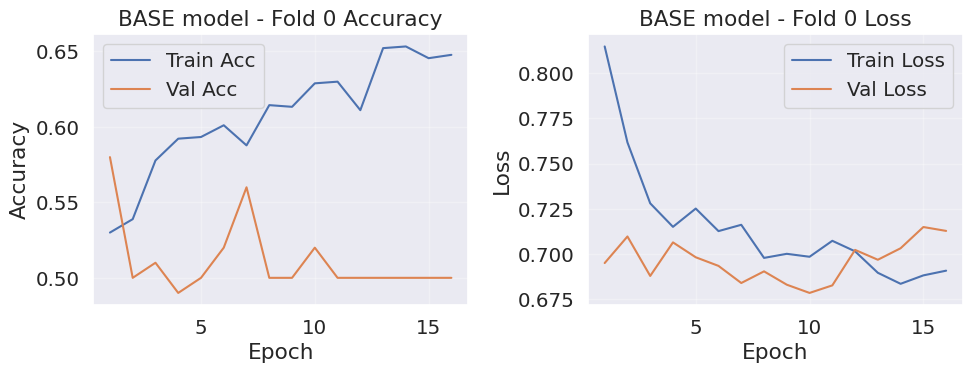

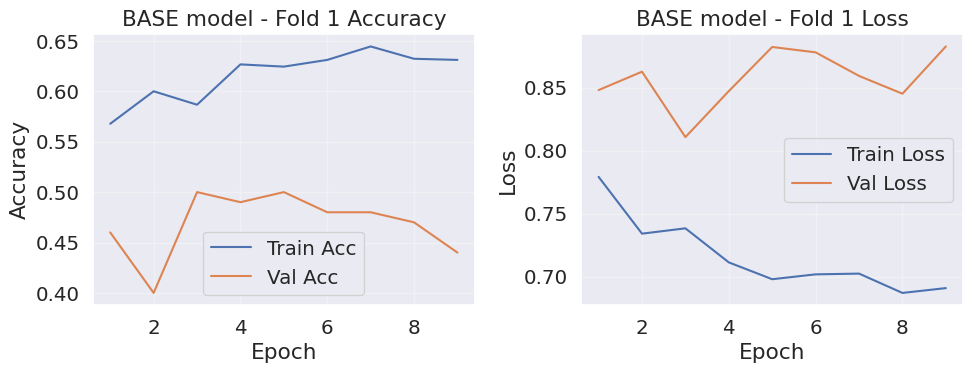

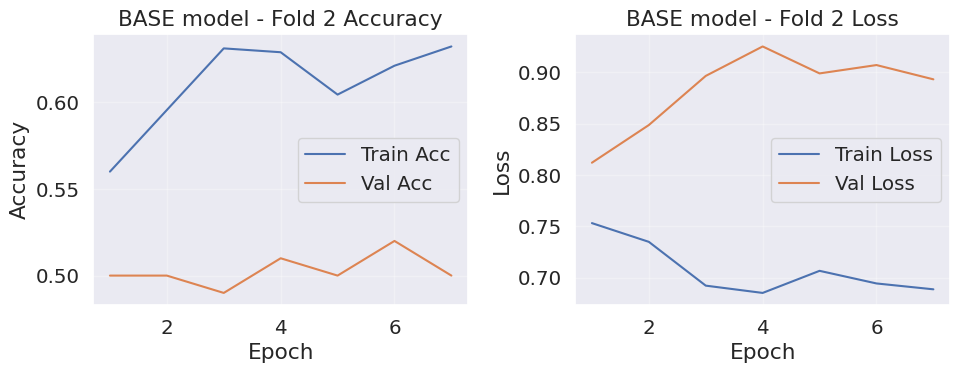

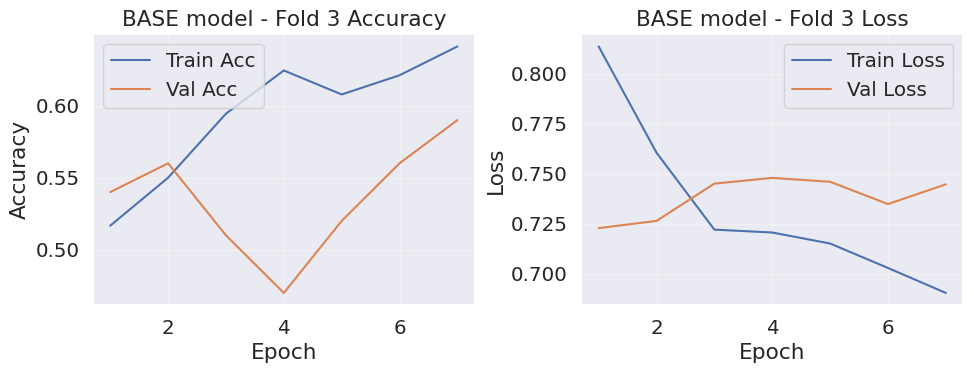

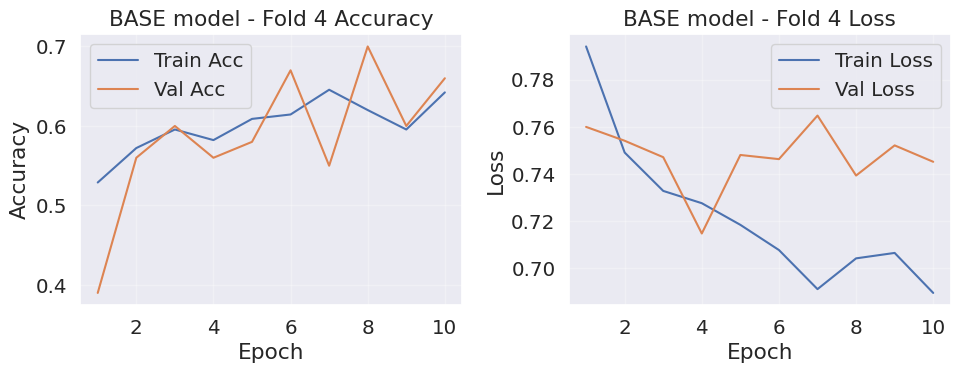

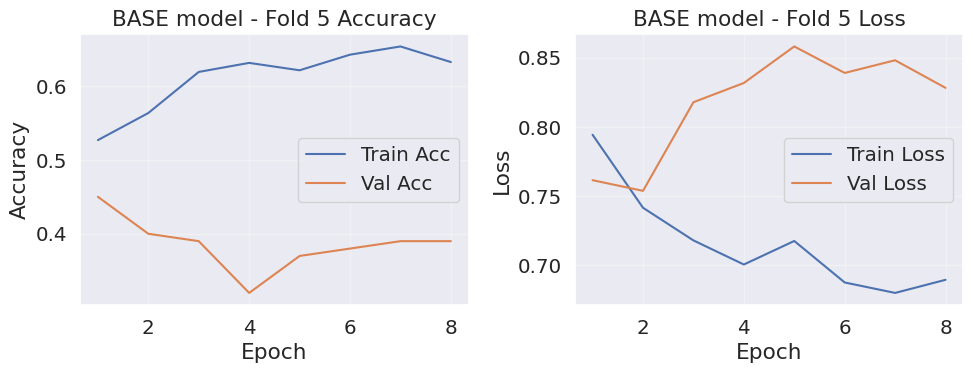

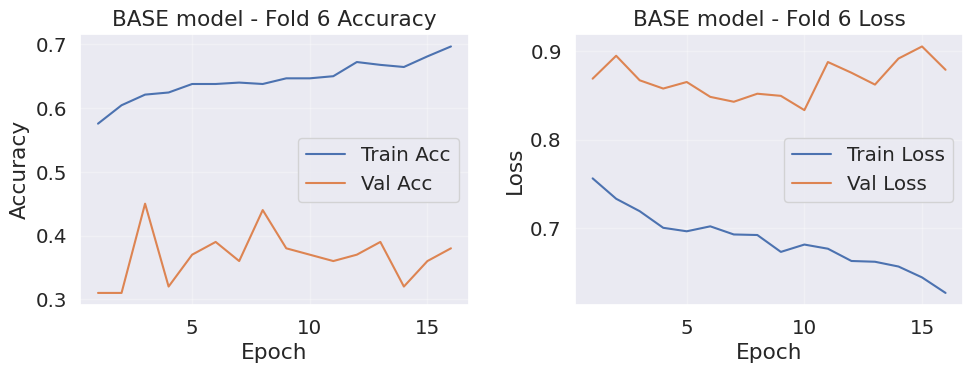

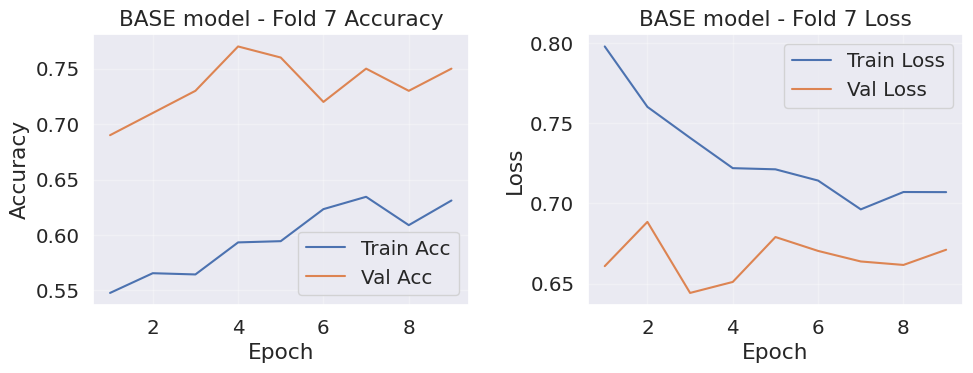

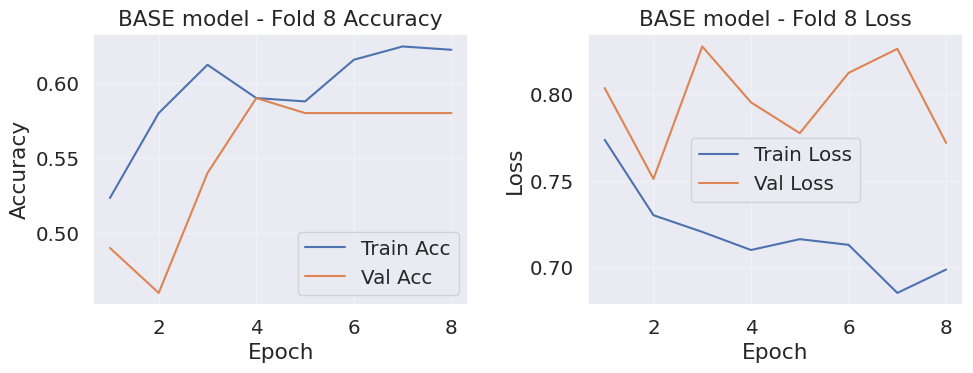

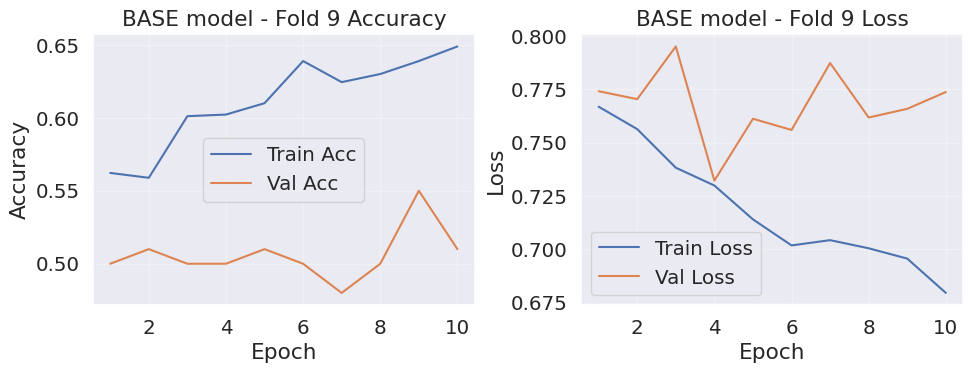

In [23]:
hist_files = sorted(
    glob.glob(os.path.join(OUT_DIR, "base_fold*_history.npy"))
)

print("Found history files:", hist_files)

for hist_path in hist_files:
    # Extract fold number from filename
    fname = os.path.basename(hist_path)
    fold_str = fname.split("fold")[1].split("_")[0]
    fold = int(fold_str)

    history = np.load(hist_path, allow_pickle=True).item()

    # Different TF versions may store metrics under different names
    acc      = history.get('accuracy', history.get('prob_accuracy', None))
    val_acc  = history.get('val_accuracy', history.get('val_prob_accuracy', None))
    loss     = history.get('loss', None)
    val_loss = history.get('val_loss', None)

    # Determine number of epochs recorded
    epochs = range(1, len(loss) + 1) if loss is not None else range(1, len(acc) + 1)

    plt.figure(figsize=(10, 4))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    if acc is not None:
        plt.plot(epochs, acc, label="Train Acc")
    if val_acc is not None:
        plt.plot(epochs, val_acc, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"BASE model - Fold {fold} Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss subplot
    plt.subplot(1, 2, 2)
    if loss is not None:
        plt.plot(epochs, loss, label="Train Loss")
    if val_loss is not None:
        plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"BASE model - Fold {fold} Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Best global threshold for BASE model: 0.360, F1=0.6881
Confusion matrix (BASE, aggregated over folds):
[[ 81 409]
 [ 28 482]]

Classification report (BASE, aggregated over folds):
              precision    recall  f1-score   support

         0.0     0.7431    0.1653    0.2705       490
         1.0     0.5410    0.9451    0.6881       510

    accuracy                         0.5630      1000
   macro avg     0.6420    0.5552    0.4793      1000
weighted avg     0.6400    0.5630    0.4834      1000



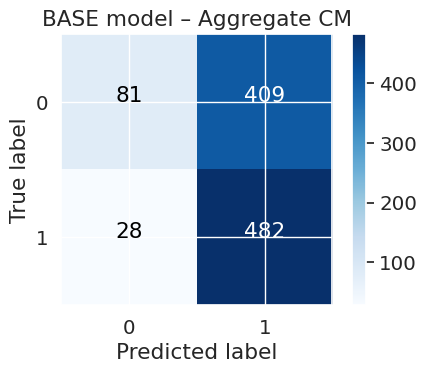

In [24]:
all_keys   = list(sample_dict.keys())
subjects   = np.array([k[0] for k in all_keys])
labels_arr = np.array([labels_user[k] for k in all_keys])
unique_subjects = np.unique(subjects)
gkf = GroupKFold(n_splits=len(unique_subjects))

all_y_true = []
all_y_prob = []

fold = 0
for train_idx, val_idx in gkf.split(all_keys, labels_arr, groups=subjects):
    val_keys = [all_keys[i] for i in val_idx]

    # Build val dataset for BASE model
    ds_val = build_dataset_from_keys(
        val_keys,
        model_type='base',
        batch_size=BATCH_SIZE,
        shuffle=False,
        augment=False  # safe even if unused
    )

    # Build BASE model with correct dims
    EEG_T     = T_TARGET
    EEG_C     = len(FEATURE_COLS)
    VIDEO_DIM = video_dim
    DEMO_DIM  = demo_onehot.shape[1]

    model = build_base_model(
        T=EEG_T,
        C=EEG_C,
        video_dim=VIDEO_DIM,
        demo_dim=DEMO_DIM
    )

    # Load checkpoint
    ckpt = os.path.join(OUT_DIR, f'base_fold{fold}.weights.h5')
    if os.path.exists(ckpt):
        model.load_weights(ckpt)
    else:
        print(f"[Warning] Checkpoint not found for fold {fold}: {ckpt}")

    # Predict for this fold
    for (x_eeg, x_vid, x_demo), yb in ds_val:
        preds = model.predict_on_batch((x_eeg, x_vid, x_demo)).reshape(-1)
        all_y_true.extend(yb.numpy().tolist())
        all_y_prob.extend(preds.tolist())

    fold += 1
    tf.keras.backend.clear_session()

# Convert to numpy
all_y_true = np.array(all_y_true)
all_y_prob = np.array(all_y_prob)

best_t = 0.5
best_f1 = -1

for t in np.linspace(0.1, 0.9, 81):
    y_bin = (all_y_prob >= t).astype(int)
    if len(set(all_y_true)) <= 1:
        continue
    f1 = f1_score(all_y_true, y_bin)
    if f1 > best_f1:
        best_f1 = f1
        best_t = t

print(f"Best global threshold for BASE model: {best_t:.3f}, F1={best_f1:.4f}")

# Final binary predictions
y_pred_bin = (all_y_prob >= best_t).astype(int)

#  Confusion Matrix
cm = confusion_matrix(all_y_true, y_pred_bin, labels=[0,1])
print("Confusion matrix (BASE, aggregated over folds):")
print(cm)

#  Classification Report
print("\nClassification report (BASE, aggregated over folds):")
print(classification_report(all_y_true, y_pred_bin, digits=4))

#  Confusion Matrix Plotter
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=['0','1'], title='BASE model – Aggregate CM')

2. Hybrid Model

In [25]:
print("Running HYBRID model...")
res_hybrid = run_loso('hybrid', epochs=EPOCHS)

Running HYBRID model...

--- Fold 0 (left-out subject(s): [np.int64(9)]) ---
Epoch 1/40
113/113 - 33s - 291ms/step - accuracy: 0.6133 - loss: 0.7007 - val_accuracy: 0.6000 - val_loss: 0.6611 - learning_rate: 2.0000e-04
Epoch 2/40
113/113 - 1s - 10ms/step - accuracy: 0.6689 - loss: 0.6557 - val_accuracy: 0.8100 - val_loss: 0.5407 - learning_rate: 2.0000e-04
Epoch 3/40
113/113 - 1s - 6ms/step - accuracy: 0.7311 - loss: 0.5732 - val_accuracy: 0.4900 - val_loss: 0.8552 - learning_rate: 2.0000e-04
Epoch 4/40
113/113 - 1s - 6ms/step - accuracy: 0.8633 - loss: 0.3938 - val_accuracy: 0.5100 - val_loss: 1.6022 - learning_rate: 2.0000e-04
Epoch 5/40
113/113 - 1s - 6ms/step - accuracy: 0.9422 - loss: 0.2624 - val_accuracy: 0.4900 - val_loss: 1.6767 - learning_rate: 2.0000e-04
Epoch 6/40
113/113 - 1s - 6ms/step - accuracy: 0.9856 - loss: 0.1853 - val_accuracy: 0.4800 - val_loss: 1.9234 - learning_rate: 1.0000e-04
Epoch 7/40
113/113 - 1s - 6ms/step - accuracy: 0.9856 - loss: 0.1861 - val_accuracy: 

Found HYBRID history files: ['./artifacts_three_models/hybrid_fold0_history.npy', './artifacts_three_models/hybrid_fold1_history.npy', './artifacts_three_models/hybrid_fold2_history.npy', './artifacts_three_models/hybrid_fold3_history.npy', './artifacts_three_models/hybrid_fold4_history.npy', './artifacts_three_models/hybrid_fold5_history.npy', './artifacts_three_models/hybrid_fold6_history.npy', './artifacts_three_models/hybrid_fold7_history.npy', './artifacts_three_models/hybrid_fold8_history.npy', './artifacts_three_models/hybrid_fold9_history.npy']


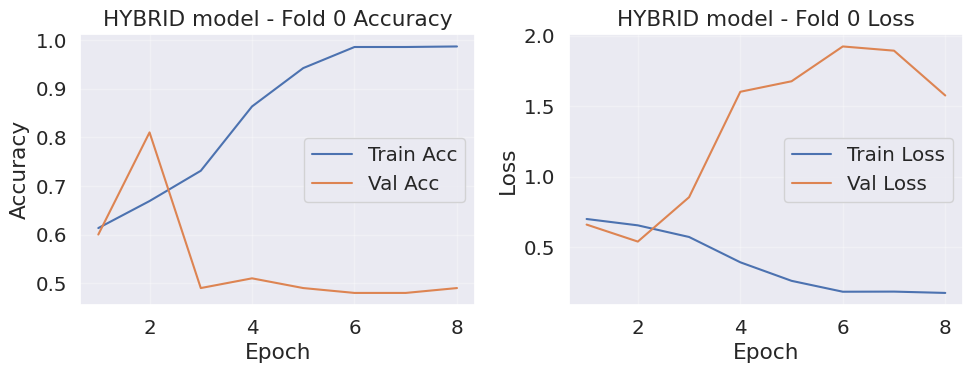

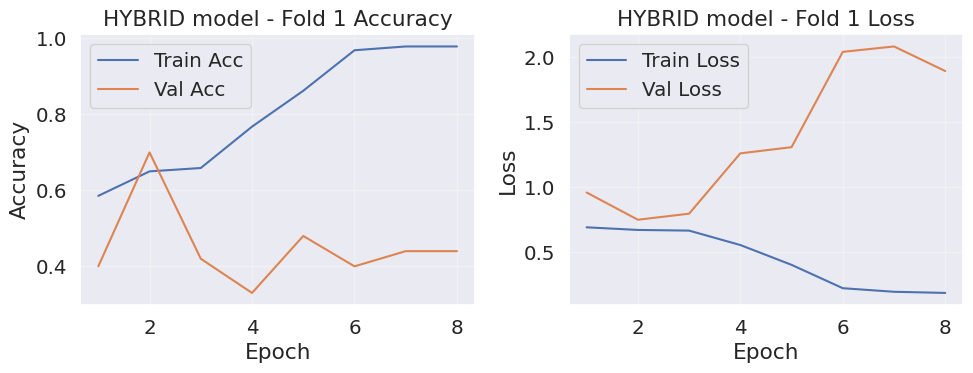

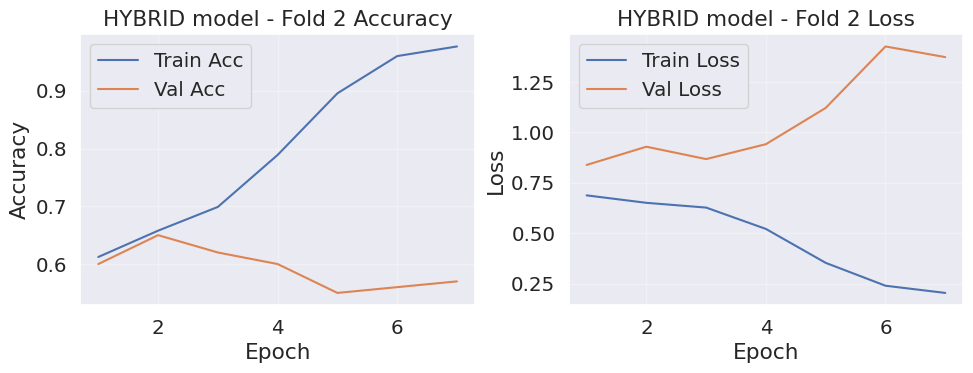

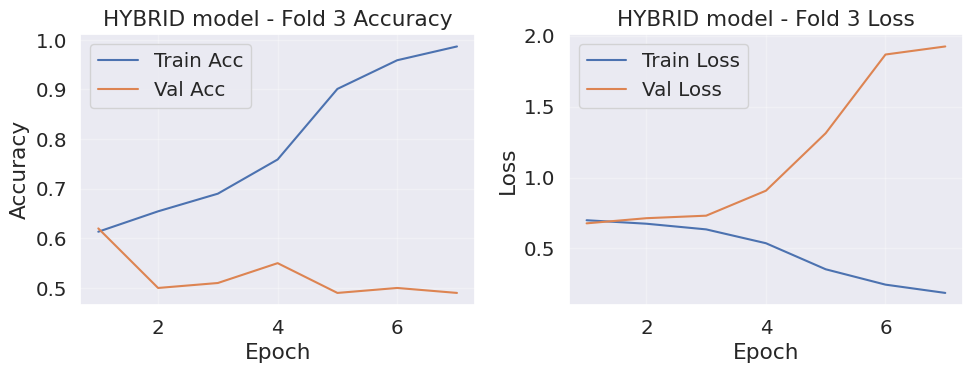

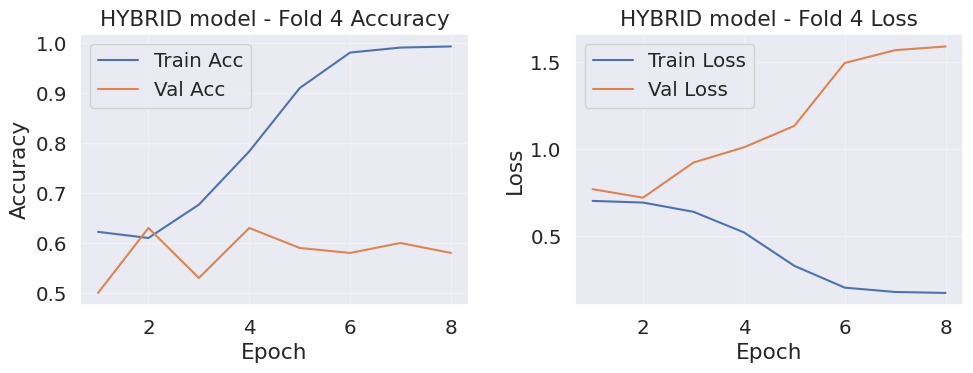

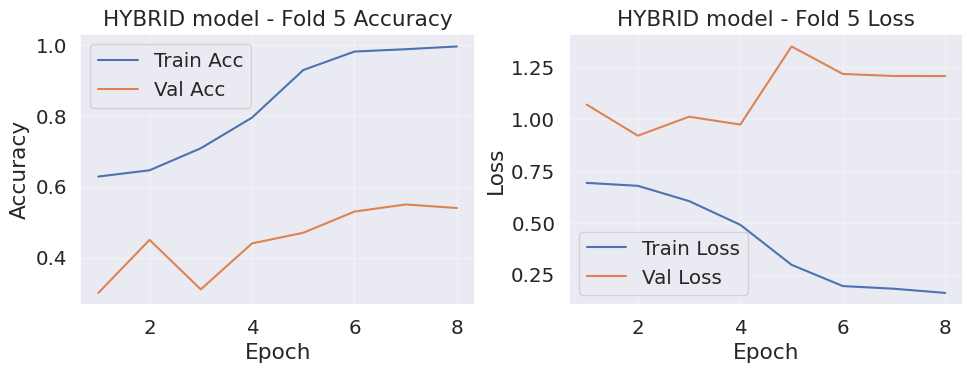

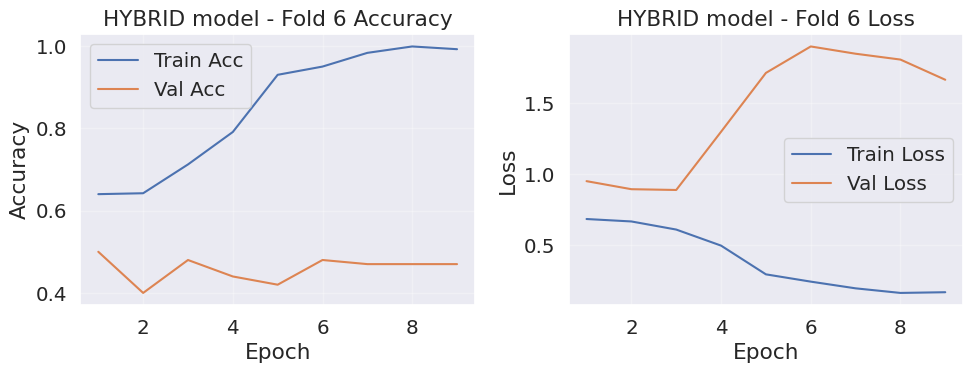

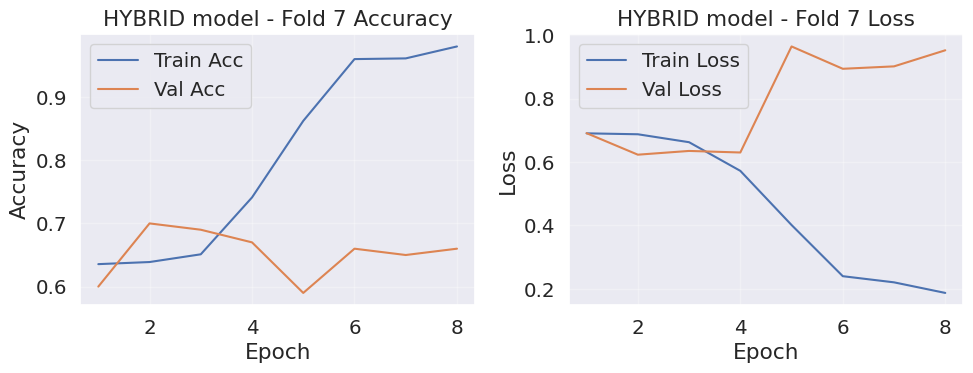

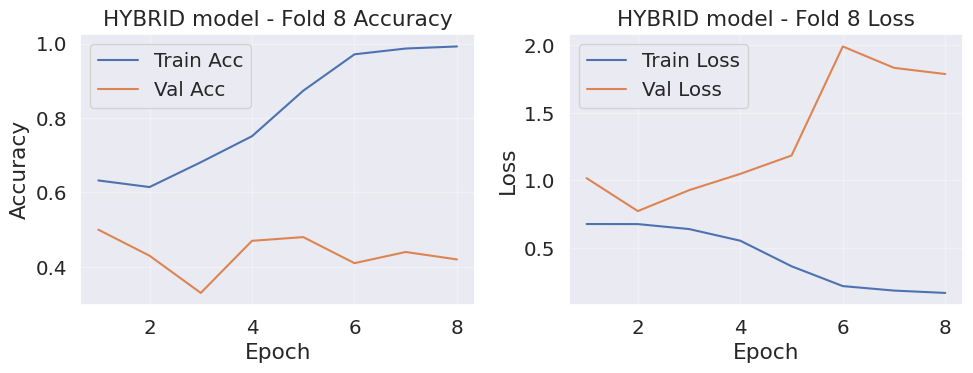

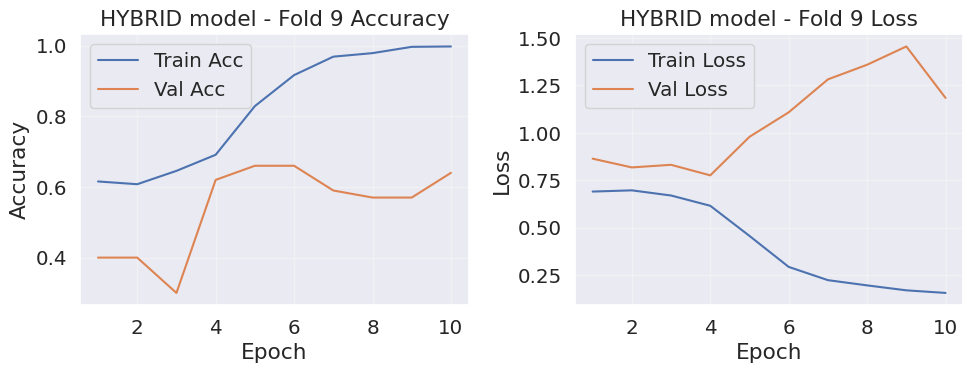

In [26]:
hist_files = sorted(
    glob.glob(os.path.join(OUT_DIR, "hybrid_fold*_history.npy"))
)

print("Found HYBRID history files:", hist_files)

for hist_path in hist_files:

    # Extract fold number
    fname = os.path.basename(hist_path)
    fold_str = fname.split("fold")[1].split("_")[0]
    fold = int(fold_str)

    # Load stored history dict
    history = np.load(hist_path, allow_pickle=True).item()

    # Metric names vary across TF versions
    acc      = history.get('accuracy', history.get('prob_accuracy', None))
    val_acc  = history.get('val_accuracy', history.get('val_prob_accuracy', None))
    loss     = history.get('loss', None)
    val_loss = history.get('val_loss', None)

    # Determine epoch count
    if loss is not None:
        epochs = range(1, len(loss) + 1)
    elif acc is not None:
        epochs = range(1, len(acc) + 1)
    else:
        print(f"[Warning] No usable metrics in hybrid fold {fold}")
        continue

    # --- Plot ---
    plt.figure(figsize=(10, 4))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    if acc is not None:
        plt.plot(epochs, acc, label="Train Acc")
    if val_acc is not None:
        plt.plot(epochs, val_acc, label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"HYBRID model - Fold {fold} Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss subplot
    plt.subplot(1, 2, 2)
    if loss is not None:
        plt.plot(epochs, loss, label="Train Loss")
    if val_loss is not None:
        plt.plot(epochs, val_loss, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"HYBRID model - Fold {fold} Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

3. Transfer Model

In [18]:
print("Running TRANSFER model...")
res_transfer = run_loso('transfer', epochs=max(12, EPOCHS//2))

Running TRANSFER model...

--- Fold 0 (left-out subject(s): [np.int64(9)]) ---
Epoch 1/20
113/113 - 38s - 336ms/step - accuracy: 0.5500 - loss: 0.7252 - val_accuracy: 0.7600 - val_loss: 0.5535 - learning_rate: 1.0000e-04
Epoch 2/20
113/113 - 2s - 19ms/step - accuracy: 0.6011 - loss: 0.6953 - val_accuracy: 0.8000 - val_loss: 0.5569 - learning_rate: 1.0000e-04
Epoch 3/20
113/113 - 2s - 18ms/step - accuracy: 0.5956 - loss: 0.6987 - val_accuracy: 0.7300 - val_loss: 0.6475 - learning_rate: 1.0000e-04
Epoch 4/20
113/113 - 3s - 26ms/step - accuracy: 0.6100 - loss: 0.6548 - val_accuracy: 0.8800 - val_loss: 0.5375 - learning_rate: 1.0000e-04
Epoch 5/20
113/113 - 5s - 40ms/step - accuracy: 0.6089 - loss: 0.6672 - val_accuracy: 0.8200 - val_loss: 0.5771 - learning_rate: 1.0000e-04
Epoch 6/20
113/113 - 2s - 18ms/step - accuracy: 0.6222 - loss: 0.6566 - val_accuracy: 0.6300 - val_loss: 0.6334 - learning_rate: 1.0000e-04
Epoch 7/20
113/113 - 3s - 22ms/step - accuracy: 0.6500 - loss: 0.6399 - val_acc

Found history files: ['./artifacts_three_models/transfer_fold0_history.npy', './artifacts_three_models/transfer_fold1_history.npy', './artifacts_three_models/transfer_fold2_history.npy', './artifacts_three_models/transfer_fold3_history.npy', './artifacts_three_models/transfer_fold4_history.npy', './artifacts_three_models/transfer_fold5_history.npy', './artifacts_three_models/transfer_fold6_history.npy', './artifacts_three_models/transfer_fold7_history.npy', './artifacts_three_models/transfer_fold8_history.npy', './artifacts_three_models/transfer_fold9_history.npy']


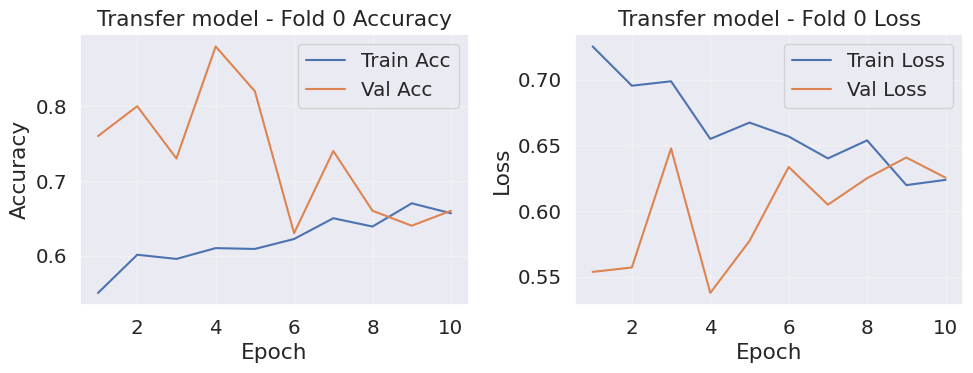

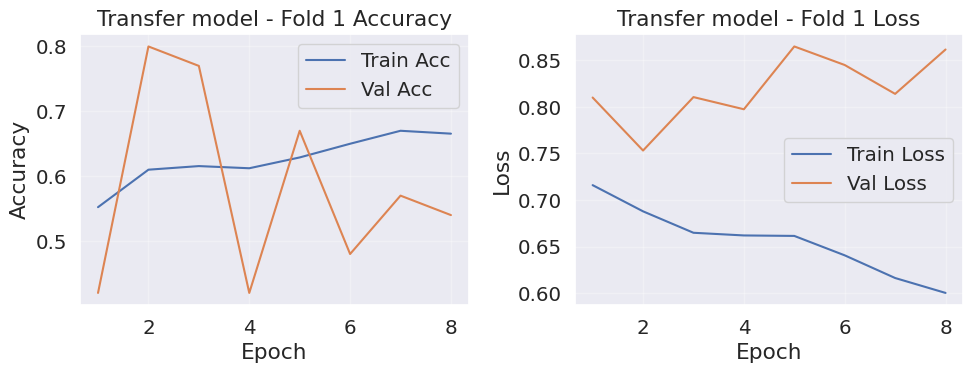

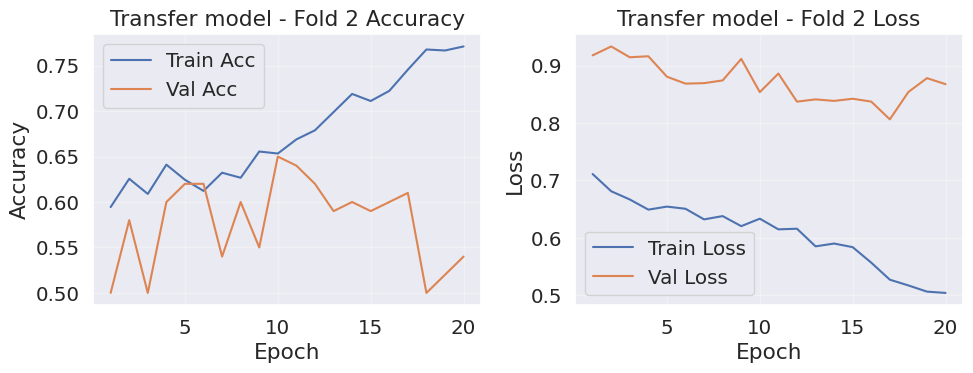

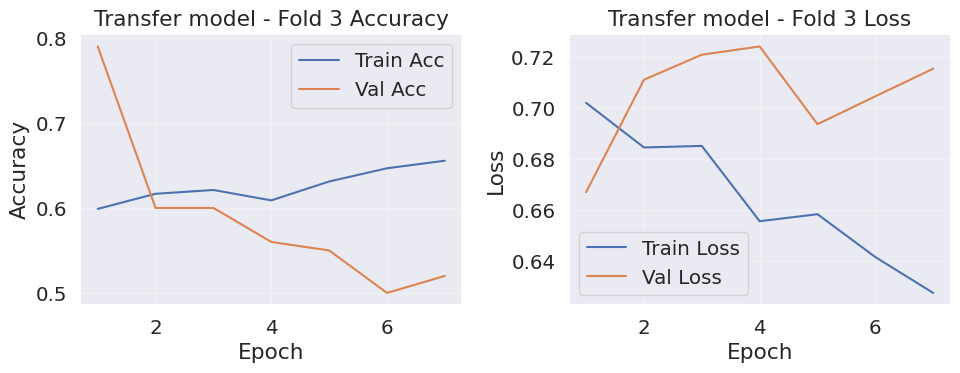

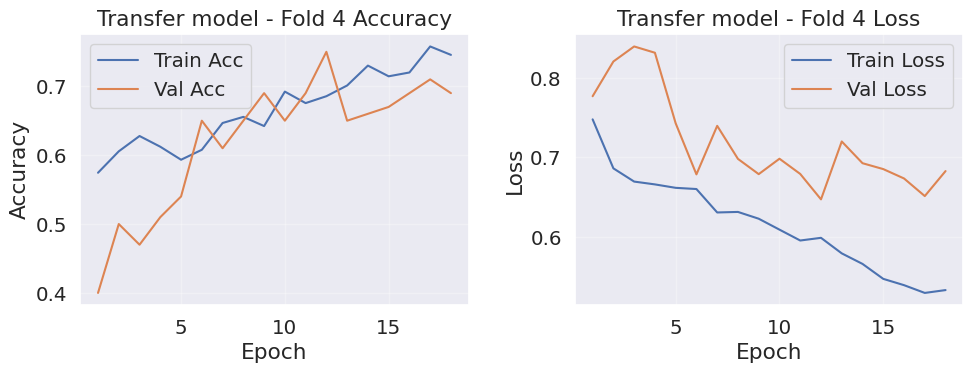

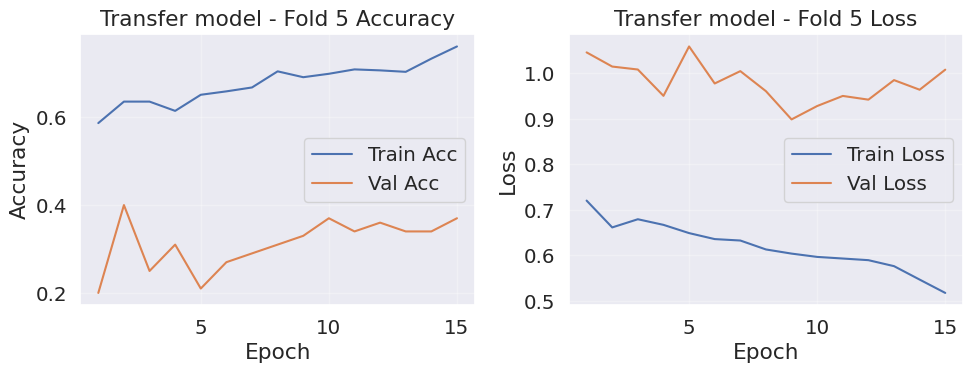

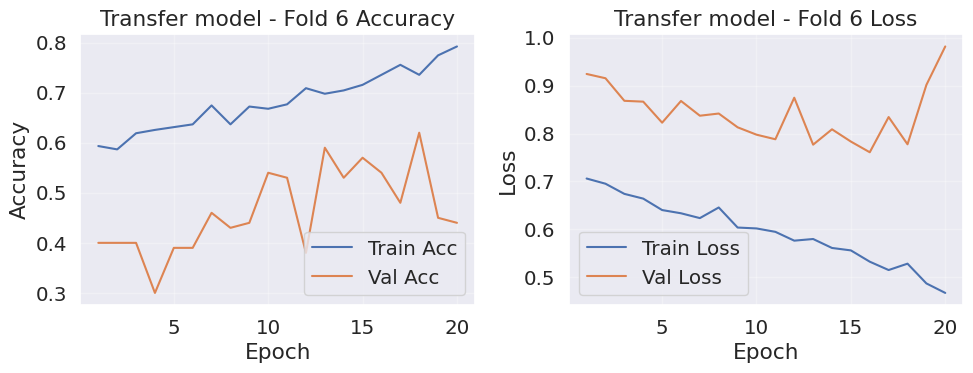

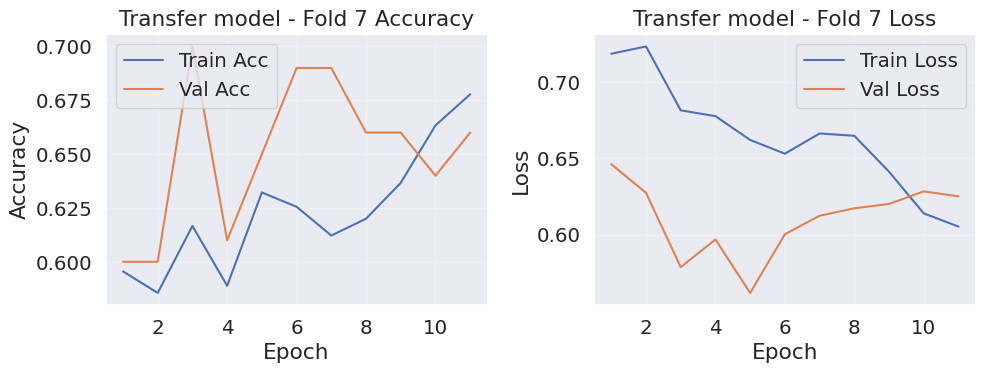

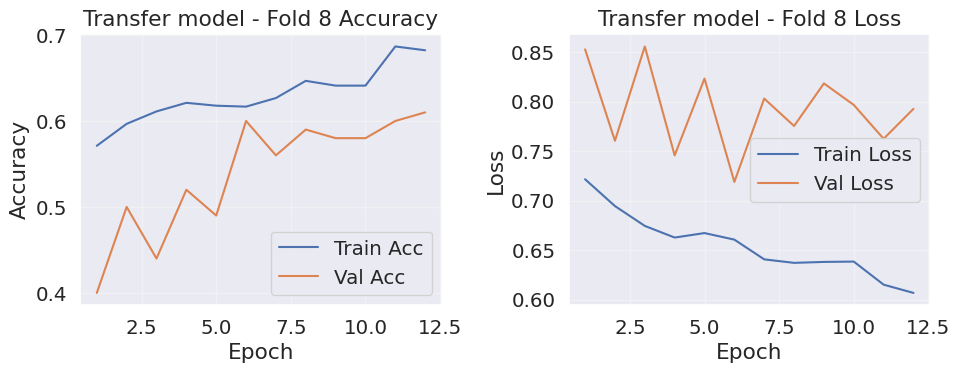

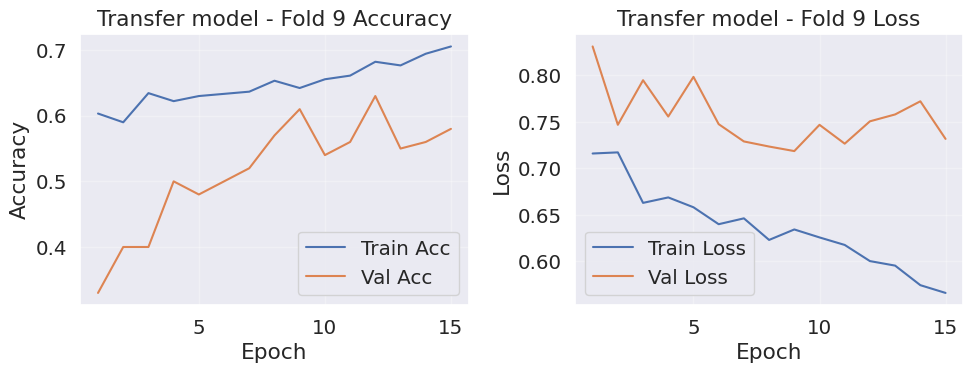

In [19]:
hist_files = sorted(
    glob.glob(os.path.join(OUT_DIR, "transfer_fold*_history.npy"))
)

print("Found history files:", hist_files)

for hist_path in hist_files:
    # Extract fold number from file name
    fname = os.path.basename(hist_path)
    # e.g. "transfer_fold0_history.npy" -> 0
    fold_str = fname.split("fold")[1].split("_")[0]
    fold = int(fold_str)

    history = np.load(hist_path, allow_pickle=True).item()

    # Keras may name metrics slightly differently depending on version
    acc     = history.get('accuracy', history.get('prob_accuracy', None))
    val_acc = history.get('val_accuracy', history.get('val_prob_accuracy', None))
    loss    = history.get('loss', None)
    val_loss= history.get('val_loss', None)

    epochs = range(1, len(loss) + 1) if loss is not None else range(1, len(acc) + 1)

    plt.figure(figsize=(10,4))

    # --- Accuracy subplot ---
    plt.subplot(1,2,1)
    if acc is not None:
        plt.plot(epochs, acc, label='Train Acc')
    if val_acc is not None:
        plt.plot(epochs, val_acc, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Transfer model - Fold {fold} Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- Loss subplot ---
    plt.subplot(1,2,2)
    if loss is not None:
        plt.plot(epochs, loss, label='Train Loss')
    if val_loss is not None:
        plt.plot(epochs, val_loss, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Transfer model - Fold {fold} Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

Best global threshold for TRANSFER model: 0.310, F1=0.6790
Confusion matrix (TRANSFER, aggregated over folds):
[[109 381]
 [ 52 458]]

Classification report (TRANSFER, aggregated over folds):
              precision    recall  f1-score   support

         0.0     0.6770    0.2224    0.3349       490
         1.0     0.5459    0.8980    0.6790       510

    accuracy                         0.5670      1000
   macro avg     0.6115    0.5602    0.5069      1000
weighted avg     0.6101    0.5670    0.5104      1000



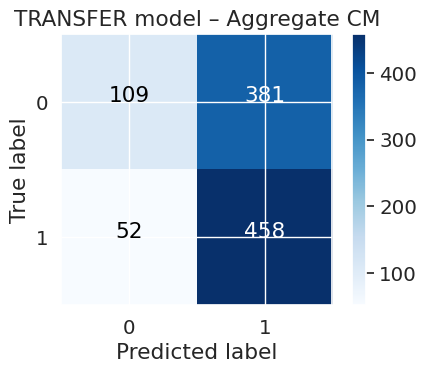

In [20]:
all_keys   = list(sample_dict.keys())
subjects   = np.array([k[0] for k in all_keys])
labels_arr = np.array([labels_user[k] for k in all_keys])
unique_subjects = np.unique(subjects)
gkf = GroupKFold(n_splits=len(unique_subjects))

all_y_true = []
all_y_prob = []

fold = 0
for train_idx, val_idx in gkf.split(all_keys, labels_arr, groups=subjects):
    val_keys = [all_keys[i] for i in val_idx]

    # Build val dataset for TRANSFER model
    ds_val = build_dataset_from_keys(
        val_keys,
        model_type='transfer',
        batch_size=BATCH_SIZE,
        shuffle=False,
        augment=False
    )

    # Rebuild transfer model with same dims
    EEG_T     = T_TARGET
    EEG_C     = len(FEATURE_COLS)
    VIDEO_DIM = video_dim
    DEMO_DIM  = demo_onehot.shape[1]

    model = build_transfer_model(
        image_size=IMG_SIZE + (3,),
        video_dim=VIDEO_DIM,
        demo_dim=DEMO_DIM
    )

    ckpt = os.path.join(OUT_DIR, f'transfer_fold{fold}.weights.h5')
    if os.path.exists(ckpt):
        model.load_weights(ckpt)
    else:
        print(f"[Warning] Checkpoint not found for fold {fold}: {ckpt}")

    # Collect predictions for this fold
    for (x_eegimg, x_vid, x_demo), yb in ds_val:
        preds = model.predict_on_batch((x_eegimg, x_vid, x_demo)).reshape(-1)
        all_y_true.extend(yb.numpy().tolist())
        all_y_prob.extend(preds.tolist())

    fold += 1
    tf.keras.backend.clear_session()

all_y_true = np.array(all_y_true)
all_y_prob = np.array(all_y_prob)

best_t = 0.5
best_f1 = -1
for t in np.linspace(0.1, 0.9, 81):
    y_bin = (all_y_prob >= t).astype(int)
    if len(set(all_y_true)) <= 1:
        continue
    f1 = f1_score(all_y_true, y_bin)
    if f1 > best_f1:
        best_f1 = f1
        best_t  = t

print(f"Best global threshold for TRANSFER model: {best_t:.3f}, F1={best_f1:.4f}")

y_pred_bin = (all_y_prob >= best_t).astype(int)

# Confusion matrix
cm = confusion_matrix(all_y_true, y_pred_bin, labels=[0,1])
print("Confusion matrix (TRANSFER, aggregated over folds):")
print(cm)

# Classification report
print("\nClassification report (TRANSFER, aggregated over folds):")
print(classification_report(all_y_true, y_pred_bin, digits=4))

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, format(cm[i, j], fmt),
            horizontalalignment='center',
            color='white' if cm[i, j] > thresh else 'black'
        )

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(cm, classes=['0','1'], title='TRANSFER model – Aggregate CM')

#Evaluation, Conclusion

Hybrid Model works best for this dataset.